In [1]:
"""
 unsupervised_ML.ipynb

 Use unsupervised learning to cluster the time series data into different groups.
"""

'\n unsupervised_ML.ipynb\n\n Use unsupervised learning to cluster the time series data into different groups.\n'

#### Libraries

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, isqrt, ceil
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler  
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import make_scorer, silhouette_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, train_test_split
from plot_elbow import plot_elbow
import io
import seaborn as sns
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve, 
    auc, 
    confusion_matrix
)

c:\Users\Anuvrat\OneDrive\Documents\siads\milestone2\venv_milestone2\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# Define common variables
data_folder = '../data/'

#### Load files

In [6]:
# Load the stock details pickle file from data folder
df_stock = pd.read_pickle(data_folder + 'df_stock.pkl')

### Using TS learn K means

In [5]:
# Define common variables
data_folder = '../data/'
seed=42
data_start_date='2023-01-01'

In [6]:
# Load top 500 dataset with Yahoo finance data
top500_data_nona = pd.read_pickle(data_folder + 'top500_data_nona.pkl')
# Load all imputed Edgar datasets
df_edgar_combined_imputed_simple_zero = pd.read_pickle(data_folder + 'df_edgar_combined_imputed_simple_zero.pkl')
df_edgar_combined_imputed_simple_mean = pd.read_pickle(data_folder + 'df_edgar_combined_imputed_simple_mean.pkl')
df_edgar_combined_imputed_simple_median = pd.read_pickle(data_folder + 'df_edgar_combined_imputed_simple_median.pkl')
df_edgar_combined_imputed_knn = pd.read_pickle(data_folder + 'df_edgar_combined_imputed_knn.pkl')
df_edgar_combined_imputed_iterative = pd.read_pickle(data_folder + 'df_edgar_combined_imputed_iterative.pkl')
df_edgar_combined_imputed_iterative_rf = pd.read_pickle(data_folder + 'df_edgar_combined_imputed_iterative_rf.pkl')

In [7]:
# Extract the adjusted close prices
close_prices_adj = top500_data_nona.xs('Adj Close', axis=1, level=0)
close_prices_adj.columns.name = None
close_prices_adj.index.name = None

In [8]:
# Define top 20 stocks based on inputs from an external source (Investopedia)
top_stocks=['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B', 'META', 'UNH', 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 'PG', 'MA', 'AVGO', 'HD', 'CVX', 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']
existing_top_stocks = [col for col in top_stocks if col in close_prices_adj.columns] #4 stocks are not in the dataset - BRK.B, ABBV, META, TSLA

In [9]:
# Select the top 20 stocks since 1st Jan 2019
close_prices_adj_top=close_prices_adj[existing_top_stocks][close_prices_adj.index>=data_start_date]
# Select all the stocks since 1st Jan 2019
close_prices_adj_all=close_prices_adj[close_prices_adj.index>=data_start_date]
# Save the dataset as a pickle file
close_prices_adj_top.to_pickle(data_folder + 'close_prices_adj_top_unsupervised.pkl')
#close_prices_adj_top.head()
# Define if top 20 or all stocks data should be used
input_data=close_prices_adj_all

In [10]:
# Calculate original mean and standard deviation of the time series data for each stock
original_means = dict(np.mean(input_data, axis=0))
original_stds = dict(np.std(input_data, axis=0))

#### Using pipeline and grid search

##### Note that you will see an error if you use a high value for both n_splits and n_clusters as each sample will be in its own cluster. Silhouette score will not be calculated and scoring function will fail.

In [11]:
# Number of splits for cross-validation
n_splits = 5

# Define the training data
X = input_data.T.to_numpy()
#print("*" * 50)
#print(f"X.shape: {X.shape}")
#print("*" * 50)

# Define the Pipeline
pipeline_kmeans=Pipeline([
            ('normalize', TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)),
            #('normalize', TimeSeriesScalerMinMax(value_range=(-1, 1))),
            ('kmeans', TimeSeriesKMeans(tol=0.1, n_init=1, random_state=seed))
    ])

# Define the parameter grid for GridSearchCV
param_grid = {
    'kmeans__n_clusters': [2, 3, 4, 5],  
    'kmeans__metric': ['dtw', 'euclidean'], 
    'kmeans__max_iter': [5, 10, 100],
    'kmeans__init': ['k-means++', 'random']
}

# Define the scoring function
class ScorerMetrics:
    def __init__(self):
        self.X_squeeze = None
        self.preds = None

    def negated_inertia(self, model, X, y=None):
        """
        Calculate the negated inertia for the given model and data.
        
        Parameters:
        - model: The unsupervised learning model used for clustering. Should have a kmeans attribute.
        
        Returns:
        - score: The negated inertia calculated for the clustering model and data.
        """
        # Calculate negated inertia
        try:        
            score = -model.named_steps['kmeans'].inertia_
        except Exception as e:
            print("Error in calcualating negated inertia:", e)
            score = 0

        # Return the silhouette score
        return score

# Instantiate the scorer
scorer = ScorerMetrics()

# Create the grid search object
grid_search_kmeans = GridSearchCV(
    estimator=pipeline_kmeans,  # Initialize with any value; GridSearchCV will override
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=n_splits),
    scoring=scorer.negated_inertia,  # Maximizing negated inertia is equivalent to minimizing its values
    #refit=False  # Avoid refitting the best estimator to the whole dataset
)

# Fit the grid search to the training data
grid_search_kmeans.fit(X)

# Best parameters found by grid search
print("Best parameters found:", grid_search_kmeans.best_params_)
# Best score
print("Best score:", grid_search_kmeans.best_score_)
# Best estimator inertia
print("Best estimator inertia:", grid_search_kmeans.best_estimator_.named_steps['kmeans'].inertia_)
# Find the Silhouette score
transformed_data = np.squeeze(grid_search_kmeans.best_estimator_.named_steps['normalize'].transform(input_data.T))
print(f"Silhouette Score: {silhouette_score(transformed_data, grid_search_kmeans.best_estimator_.predict(input_data.T))}")
# Print mean test score and rank test score
mean_test_score, rank_test_score = grid_search_kmeans.cv_results_['mean_test_score'], grid_search_kmeans.cv_results_['rank_test_score']
mean_test_score, rank_test_score
# Get all the results across the grid search
dict_cv_results = grid_search_kmeans.cv_results_
print(f"Available output keys from grid search: {dict_cv_results.keys()}")
#Find out details of the best estimator
print("Best estimator:")
display(grid_search_kmeans.best_estimator_)


Best parameters found: {'kmeans__init': 'random', 'kmeans__max_iter': 10, 'kmeans__metric': 'dtw', 'kmeans__n_clusters': 5}
Best score: -18.622243340713936
Best estimator inertia: 19.747767128010327
Silhouette Score: 0.1575345683922102
Available output keys from grid search: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_kmeans__init', 'param_kmeans__max_iter', 'param_kmeans__metric', 'param_kmeans__n_clusters', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best estimator:


Pipeline(steps=[('normalize', TimeSeriesScalerMeanVariance()),
                ('kmeans',
                 TimeSeriesKMeans(init='random', max_iter=10, metric='dtw',
                                  n_clusters=5, random_state=42, tol=0.1))])

In [66]:
# Save the results of the grid search to a CSV file
pd.DataFrame(grid_search_kmeans.cv_results_).to_csv(data_folder + 'grid_search_kmeans_results.csv', index=False)

In [12]:
# Save the best estimator as a pickle file
grid_search_kmeans.best_estimator_.named_steps['kmeans'].to_pickle(data_folder + 'best_estimator_kmeans_unsupervised.pkl')

In [13]:
# Load the best estimator from the pickle file

In [14]:
# Printing details for the best estimator
dict_cv_results['rank_test_score'][grid_search_kmeans.best_index_], \
dict_cv_results['mean_test_score'][grid_search_kmeans.best_index_], \
dict_cv_results['params'][grid_search_kmeans.best_index_]

(1,
 -18.622243340713936,
 {'kmeans__init': 'random',
  'kmeans__max_iter': 10,
  'kmeans__metric': 'dtw',
  'kmeans__n_clusters': 5})

#### Details on the selected model

In [15]:
# Preprocess the data
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
#scaler = TimeSeriesScalerMinMax(value_range=(-1, 1))
X_normalized = scaler.fit_transform(input_data.T)

In [16]:
# Define the TS clustering model based on the best parameters from the grid search
iterations=grid_search_kmeans.best_params_['kmeans__max_iter'] #10
distance_metric=grid_search_kmeans.best_params_['kmeans__metric'] #'dtw' #[“euclidean”, “dtw”, “softdtw”] (default: “euclidean”)
num_clusters=grid_search_kmeans.best_params_['kmeans__n_clusters'] #5
tolerance=0.1
num_init=1
init_algo=grid_search_kmeans.best_params_['kmeans__init'] #'random' #[]'random', 'k-means++']
best_model = TimeSeriesKMeans(tol=tolerance, n_init=num_init, random_state=seed, init=init_algo, n_clusters=num_clusters, metric=distance_metric, max_iter=iterations)

In [17]:
# Fit the model and predict from the data
pred_cluster=best_model.fit_predict(X_normalized)

In [18]:
# Evaluation of the clusters
print(f"Inertia: {best_model.inertia_}")
print(f"Silhouette Score: {silhouette_score(np.squeeze(X_normalized), pred_cluster)}") #X[:, :, 0]

Inertia: 19.747767128010327
Silhouette Score: 0.1575345683922102


DTW Scaled: Inertia: 11, Silhouette Score: 0.13 || 
DTW Non-scaled: Inertia: 227879, Silhouette Score: 0.56

SoftDTW Non-scaled: Inertia: 86959127000, Silhouette Score: 0.56

In [19]:
# Create a dictionary of the predicted clusters for each stock
dict_predicted_clusters_ts=dict(zip(input_data.columns, pred_cluster))

In [20]:
# Check the distribution of the clusters
pd.DataFrame(dict_predicted_clusters_ts.items(), columns=['Stock', 'Cluster']).sort_values(by='Cluster').Cluster.value_counts()

Cluster
3    155
4    124
2     74
0     59
1     20
Name: count, dtype: int64

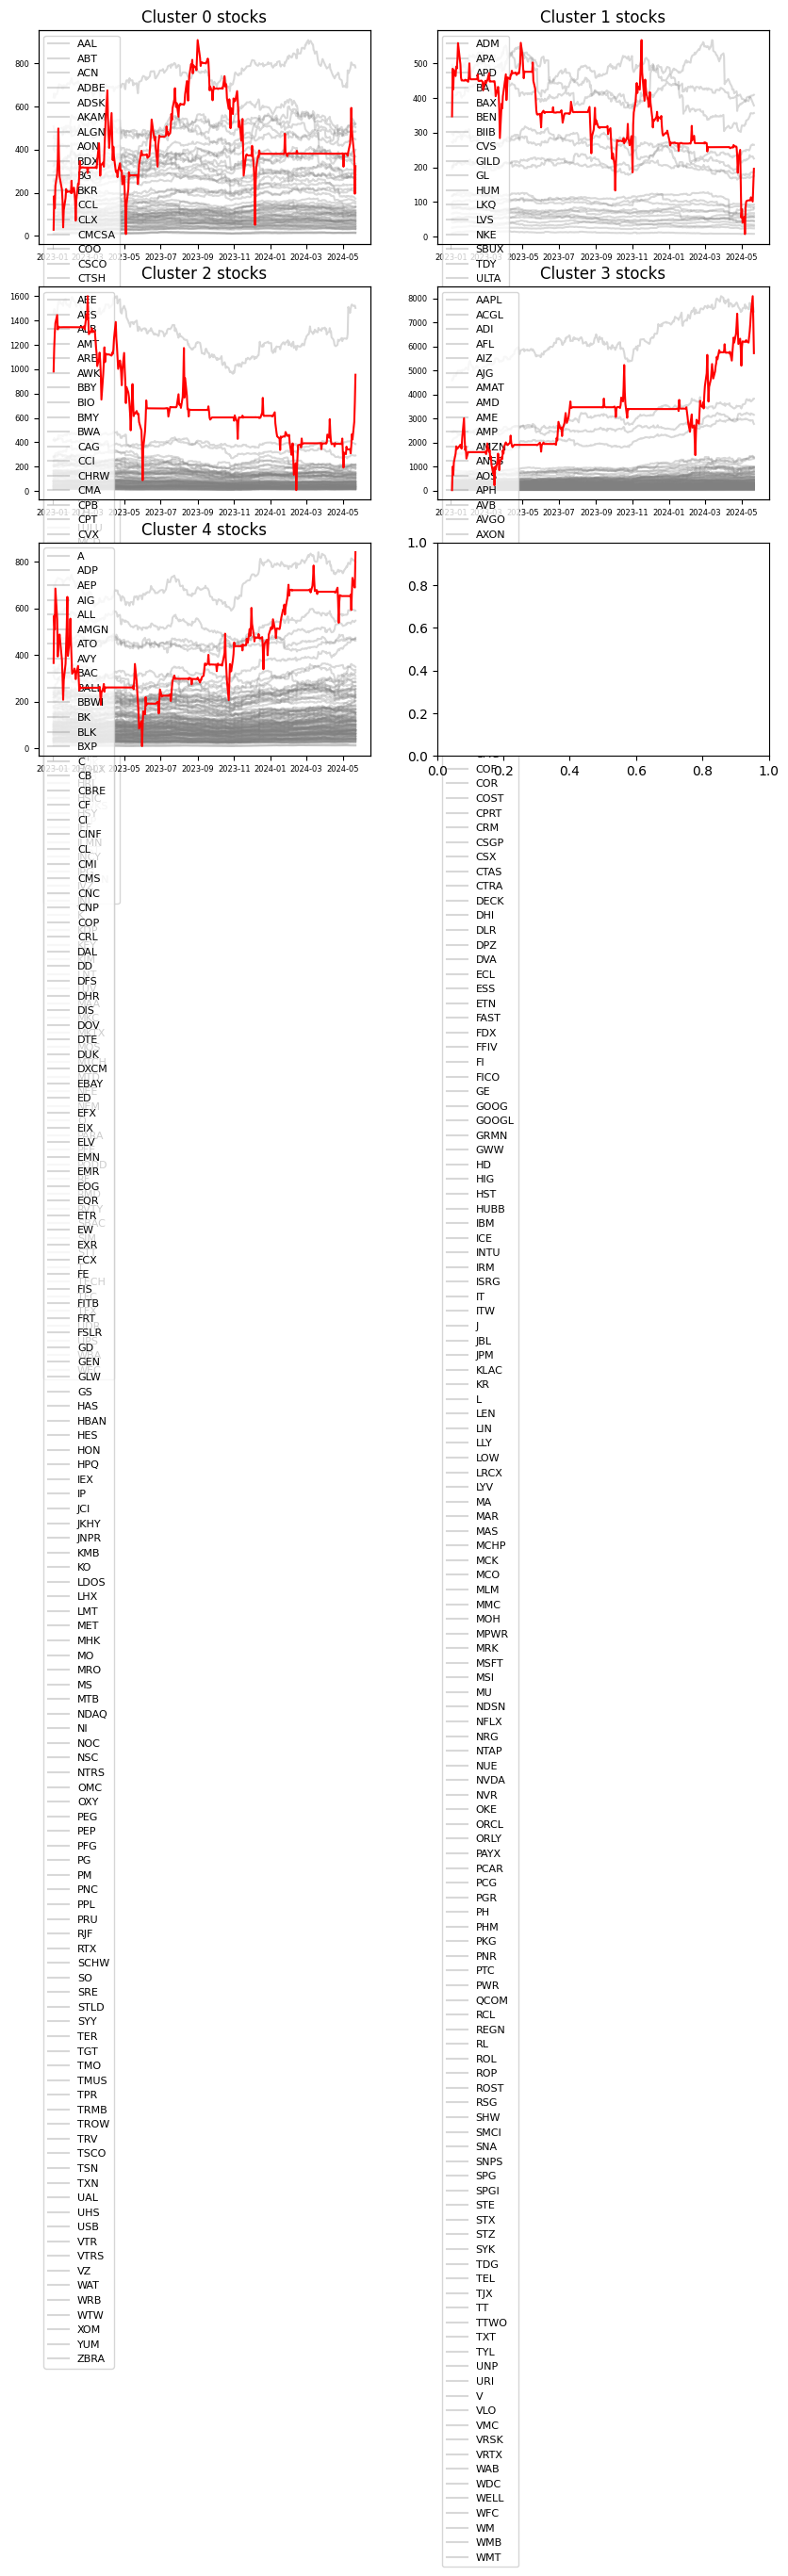

In [21]:
# Plot the clusters
int_sqrt = isqrt(num_clusters)
full_sqrt = sqrt(num_clusters)

if int_sqrt==full_sqrt: #Check if the number of clusters is a perfect square
    nrows=int_sqrt
    ncols=int_sqrt
else:
    nrows=int_sqrt+1
    ncols=ceil(num_clusters/(int_sqrt+1))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i in range(num_clusters):
    if nrows==1:
        ax=axs[i]
    else:
        ax=axs[i//ncols, i%ncols]
    
    stocks_in_cluster = [key for key in dict_predicted_clusters_ts if dict_predicted_clusters_ts[key] == i]
    ax.plot(input_data[stocks_in_cluster], color='gray', alpha=0.3)
    # Use secondary y-axis to plot the mean and standard deviation of the original data
    ax2 = ax.twinx()
    ax2.plot(input_data[stocks_in_cluster].index, best_model.cluster_centers_[i].ravel(), 'r')

    # Turn off the secondary y-axis
    ax2.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', labelsize=6)  
    ax.tick_params(axis='y', labelsize=6)  
    ax.set_title(f'Cluster {i} stocks') #{stocks_in_cluster}
    ax.legend(stocks_in_cluster, loc='upper left', fontsize=8)

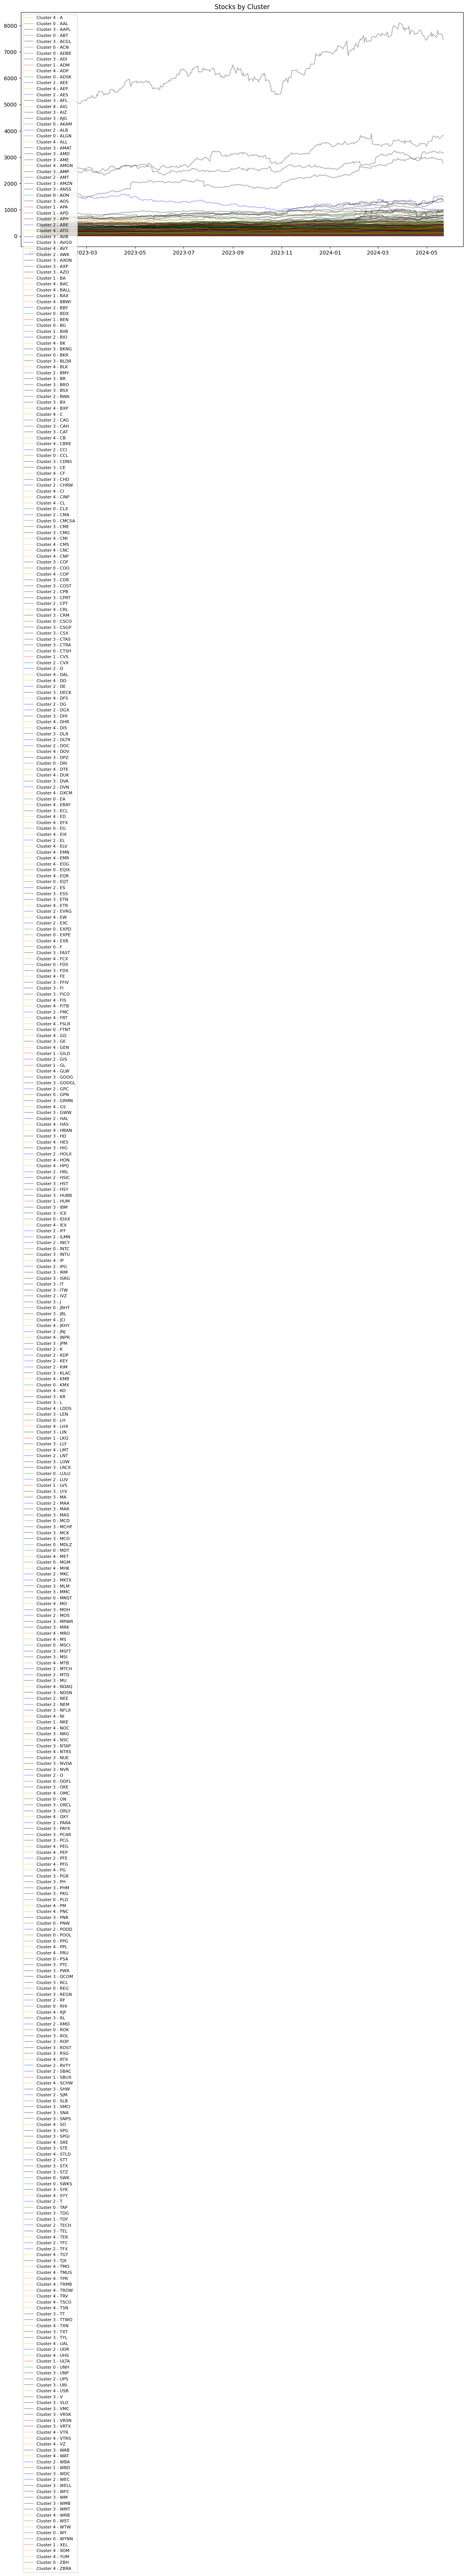

In [22]:
# Number of clusters
num_clusters = len(set(dict_predicted_clusters_ts.values()))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

dict_color = {0: 'green', 1: 'red', 2: 'blue', 3: 'black', 4: 'orange'}

# Plot each stock with its cluster color and add a label for the legend
for key in dict_predicted_clusters_ts:
    cluster = dict_predicted_clusters_ts[key]
    ax.plot(input_data[key], color=dict_color[cluster], alpha=0.3, label=f'Cluster {cluster} - {key}')

# Using a dictionary to avoid duplicate labels in the legend and to track them
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', fontsize=8)

ax.set_title('Stocks by Cluster')
plt.show()


##### X vs X normalized

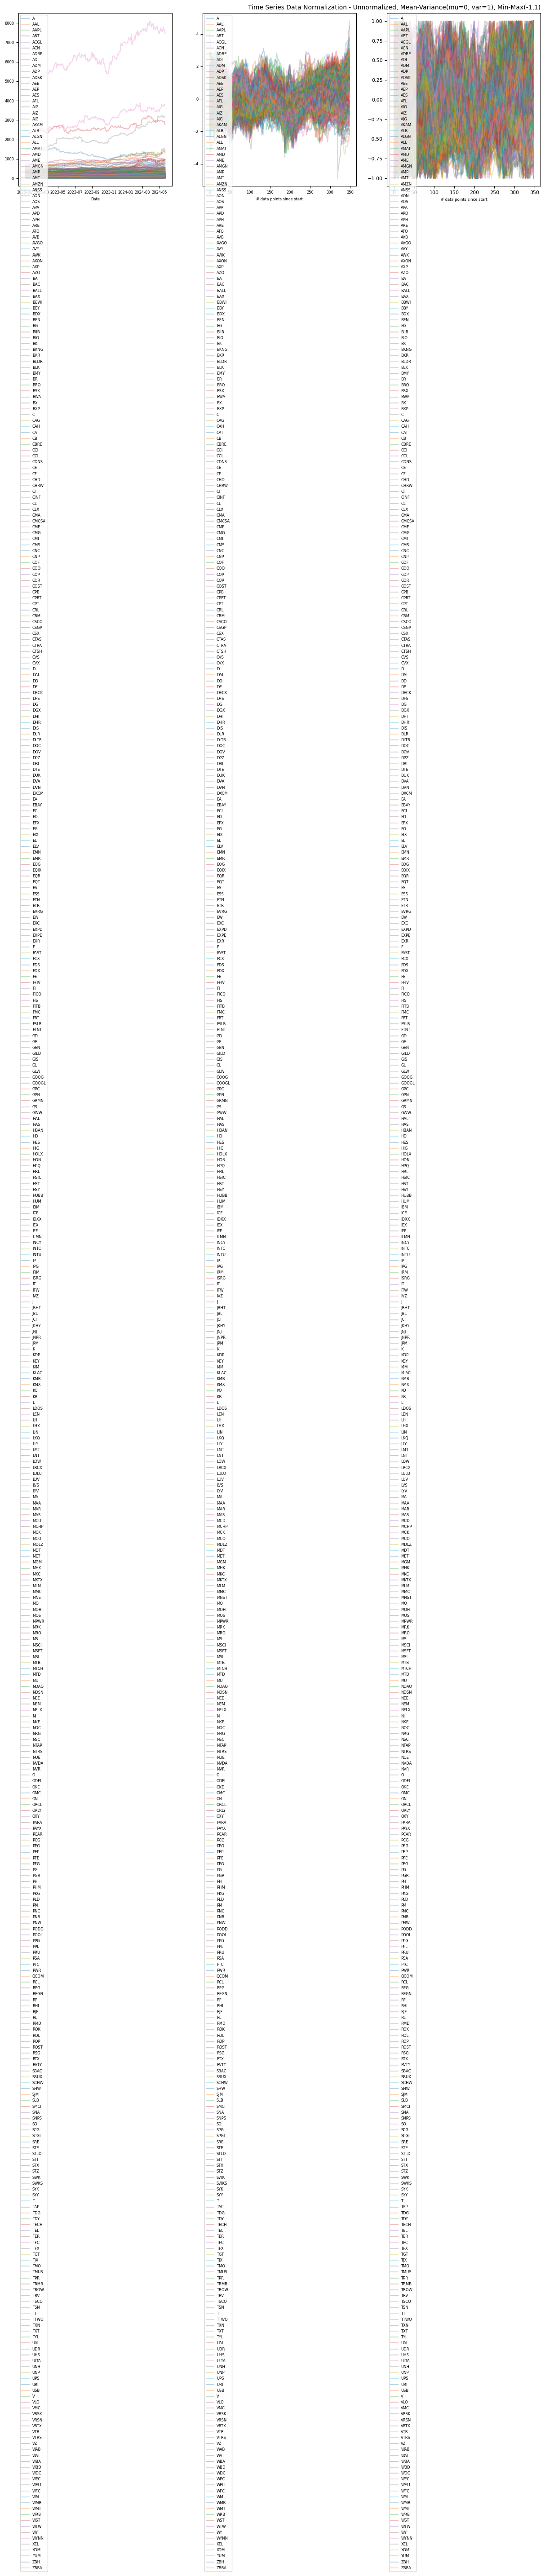

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].plot(input_data, alpha=0.3)
plt.legend(input_data.columns, loc='upper left', fontsize=8)
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)

ax[1].plot(np.array([scaler.fit_transform(np.array(input_data[stock].values).reshape(1, -1)).flatten()
                                           for stock in input_data.columns]
                                           ).T, alpha=0.3);

scaler=TimeSeriesScalerMinMax(value_range=(-1, 1))
ax[2].plot(np.array([
    scaler.fit_transform(np.array(input_data[stock].values).reshape(1, -1)).flatten()
    for stock in input_data.columns
]).T, alpha=0.3);
ax[0].legend(input_data.columns, loc='upper left', fontsize=6)
ax[1].legend(input_data.columns, loc='upper left', fontsize=6)
ax[2].legend(input_data.columns, loc='upper left', fontsize=6)
for _ in ax:
    _.tick_params(axis='x', labelsize=6)  
    _.tick_params(axis='y', labelsize=6)  
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Time Series Data Normalization - Unnormalized, Mean-Variance(mu=0, var=1), Min-Max(-1,1)', loc="right", fontsize=10)
ax[0].set_xlabel('Date', fontsize=6)
ax[1].set_xlabel('# data points since start', fontsize=6)
ax[2].set_xlabel('# data points since start', fontsize=6)
plt.show();

### Using a different approach - Kmeans on aggregated data

In [132]:
#Calculating annual mean returns and variances - There are typically 252 trading days in a year
returns = input_data.pct_change().mean() * 252
variance = input_data.pct_change().std() * sqrt(252)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]

In [133]:
# Naming imputed datasets
df_edgar_combined_imputed_simple_zero.name="df_edgar_combined_imputed_simple_zero"
df_edgar_combined_imputed_simple_mean.name="df_edgar_combined_imputed_simple_mean"
df_edgar_combined_imputed_simple_median.name="df_edgar_combined_imputed_simple_median"
df_edgar_combined_imputed_knn.name="df_edgar_combined_imputed_knn"
df_edgar_combined_imputed_iterative.name="df_edgar_combined_imputed_iterative"
df_edgar_combined_imputed_iterative_rf.name="df_edgar_combined_imputed_iterative_rf"

In [134]:
df_edgar_combined_imputed_iterative_rf.shape, ret_var.shape

((428, 43), (432, 2))

In [135]:
# Replotting elbow curve with SSE and Silhouette Score
elbow_curves_plt = {}
elbow_curves_sse = {}
elbow_curves_silhouette = {}
elbow_curves_preds={}
for imputed_data in [
    df_edgar_combined_imputed_simple_zero,
    df_edgar_combined_imputed_simple_mean,
    df_edgar_combined_imputed_simple_median,
    df_edgar_combined_imputed_knn,
    df_edgar_combined_imputed_iterative,
    df_edgar_combined_imputed_iterative_rf,
]:
    kmeans_data_raw = ret_var.merge(
        imputed_data.set_index("sym"), left_index=True, right_index=True, how="inner"
    )

    kmeans_data = pd.DataFrame(StandardScaler().fit_transform(kmeans_data_raw), columns=kmeans_data_raw.columns, index=kmeans_data_raw.index)

    (
        elbow_curves_plt[imputed_data.name],
        elbow_curves_sse[imputed_data.name],
        elbow_curves_silhouette[imputed_data.name],
        elbow_curves_preds[imputed_data.name],
    ) = plot_elbow(kmeans_data, title=f"Elbow curve for {imputed_data.name}", plot=False)

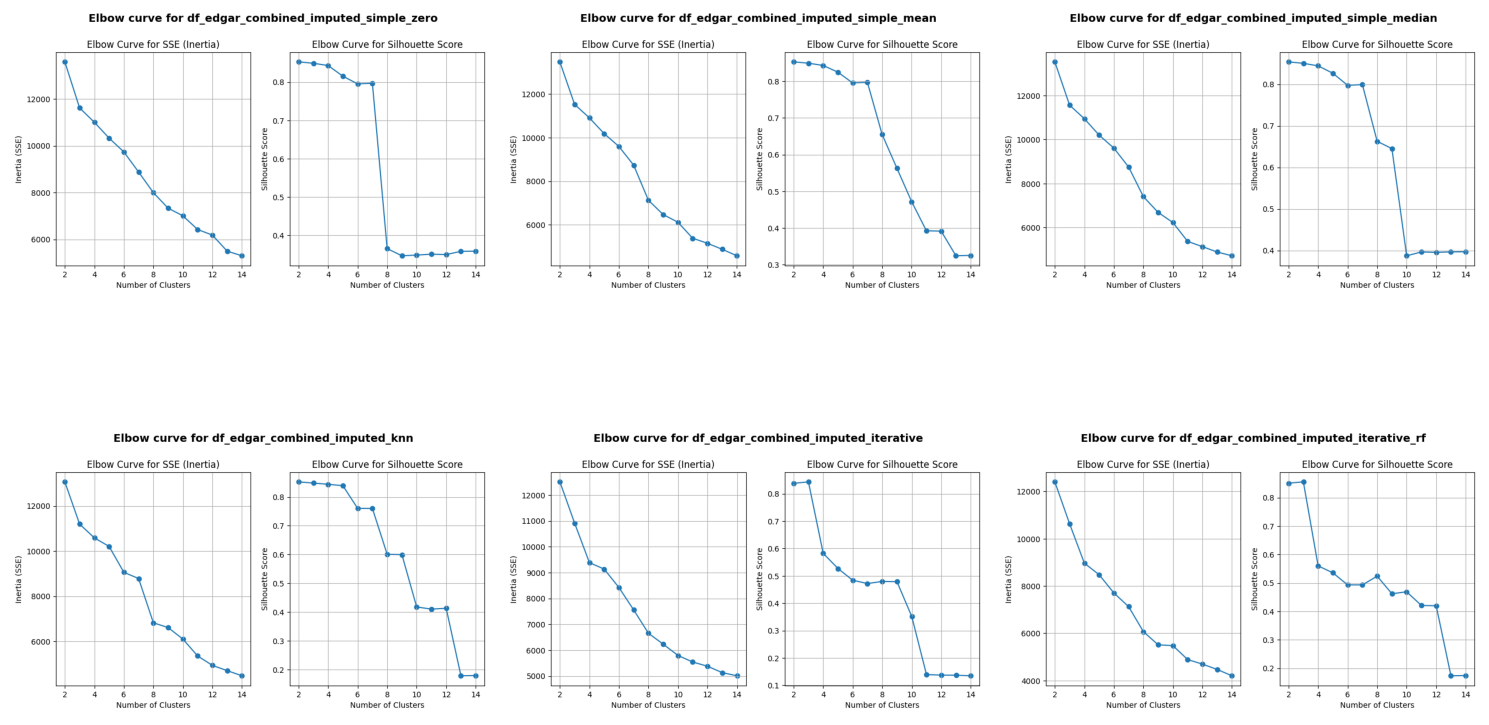

In [136]:
# Show all elbow curves in a single figure
# Save each figure to a buffer
buffers = []
for fig in elbow_curves_plt.values():
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    buffers.append(buf)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Display each saved image in the corresponding subplot
for ax, buf in zip(axs.flatten(), buffers):
    img = plt.imread(buf)
    ax.imshow(img)
    ax.axis('off')  # Turn off axis

# Adjust layout
plt.tight_layout()

# Display the combined figure
plt.show()

# Close all the individual figures to avoid memory leaks
for fig in elbow_curves_plt.values():
    plt.close(fig)

In [137]:
pd.DataFrame(elbow_curves_sse)

df_edgar_combined_imputed_simple_zero  \
0                                13584.83   
1                                11617.39   
2                                11005.52   
3                                10327.31   
4                                 9737.31   
5                                 8878.99   
6                                 7997.40   
7                                 7333.34   
8                                 7008.96   
9                                 6422.96   
10                                6184.68   
11                                5498.37   
12                                5301.24   

    df_edgar_combined_imputed_simple_mean  \
0                                13476.70   
1                                11525.10   
2                                10908.36   
3                                10185.19   
4                                 9595.07   
5                                 8737.06   
6                                 7127.33   
7                                 6468.18   
8                                 6117.09   
9                                 5381.50   
10                                5148.37   
11                                4873.13   
12                                4574.83   

    df_edgar_combined_imputed_simple_median  df_edgar_combined_imputed_knn  \
0                                  13523.47                       13063.35   
1                                  11557.22                       11194.11   
2                                  10942.49                       10583.67   
3                                  10198.20                       10203.55   
4                                   9607.73                        9056.81   
5                                   8749.52                        8781.21   
6                                   7404.21                        6820.75   
7                                   6687.65                        6609.47   
8                                   6228.97                        6099.28   
9                                   5371.38                        5351.10   
10                                  5133.90                        4934.24   
11                                  4889.06                        4701.96   
12                                  4718.36                        4473.96   

    df_edgar_combined_imputed_iterative  \
0                              12506.32   
1                              10906.19   
2                               9384.01   
3                               9135.00   
4                               8422.21   
5                               7555.60   
6                               6654.05   
7                               6231.66   
8                               5796.36   
9                               5542.84   
10                              5378.95   
11                              5132.25   
12                              5010.24   

    df_edgar_combined_imputed_iterative_rf  
0                                 12404.49  
1                                 10632.46  
2                                  8965.73  
3                                  8477.14  
4                                  7705.01  
5                                  7126.19  
6                                  6068.49  
7                                  5510.65  
8                                  5477.43  
9                                  4887.45  
10                                 4695.06  
11                                 4468.82  
12                                 4200.89

In [138]:
pd.DataFrame(elbow_curves_silhouette)

df_edgar_combined_imputed_simple_zero  \
0                                    0.85   
1                                    0.85   
2                                    0.84   
3                                    0.82   
4                                    0.80   
5                                    0.80   
6                                    0.37   
7                                    0.35   
8                                    0.35   
9                                    0.35   
10                                   0.35   
11                                   0.36   
12                                   0.36   

    df_edgar_combined_imputed_simple_mean  \
0                                    0.85   
1                                    0.85   
2                                    0.84   
3                                    0.82   
4                                    0.80   
5                                    0.80   
6                                    0.65   
7                                    0.56   
8                                    0.47   
9                                    0.39   
10                                   0.39   
11                                   0.32   
12                                   0.33   

    df_edgar_combined_imputed_simple_median  df_edgar_combined_imputed_knn  \
0                                      0.85                           0.85   
1                                      0.85                           0.85   
2                                      0.84                           0.84   
3                                      0.83                           0.84   
4                                      0.80                           0.76   
5                                      0.80                           0.76   
6                                      0.66                           0.60   
7                                      0.65                           0.60   
8                                      0.39                           0.42   
9                                      0.40                           0.41   
10                                     0.40                           0.41   
11                                     0.40                           0.18   
12                                     0.40                           0.18   

    df_edgar_combined_imputed_iterative  \
0                                  0.84   
1                                  0.84   
2                                  0.58   
3                                  0.53   
4                                  0.48   
5                                  0.47   
6                                  0.48   
7                                  0.48   
8                                  0.35   
9                                  0.14   
10                                 0.14   
11                                 0.14   
12                                 0.13   

    df_edgar_combined_imputed_iterative_rf  
0                                     0.85  
1                                     0.86  
2                                     0.56  
3                                     0.54  
4                                     0.49  
5                                     0.49  
6                                     0.52  
7                                     0.46  
8                                     0.47  
9                                     0.42  
10                                    0.42  
11                                    0.17  
12                                    0.17

#### Selected KMeans

In [139]:
# Define the best imputed dataset based on the elbow curve
kmeans_data_raw = ret_var.merge(
    df_edgar_combined_imputed_iterative_rf.set_index("sym"), left_index=True, right_index=True, how="inner"
)

kmeans_data = pd.DataFrame(
    StandardScaler().fit_transform(kmeans_data_raw),
    columns=kmeans_data_raw.columns,
    index=kmeans_data_raw.index,
)

# Define the kmeans with best imputed dataset and # of clusters
kmeans = KMeans(n_clusters=7, random_state=seed).fit(kmeans_data)
centroids = kmeans.cluster_centers_
kmeans_data_raw["cluster"] = kmeans.labels_

#### Correlation matrix

In [140]:
# Save the correlation matrix to a CSV file
correlation_matrix=kmeans_data.corr()
correlation_matrix.to_csv(data_folder + 'correlation_matrix_unsupervised.csv')

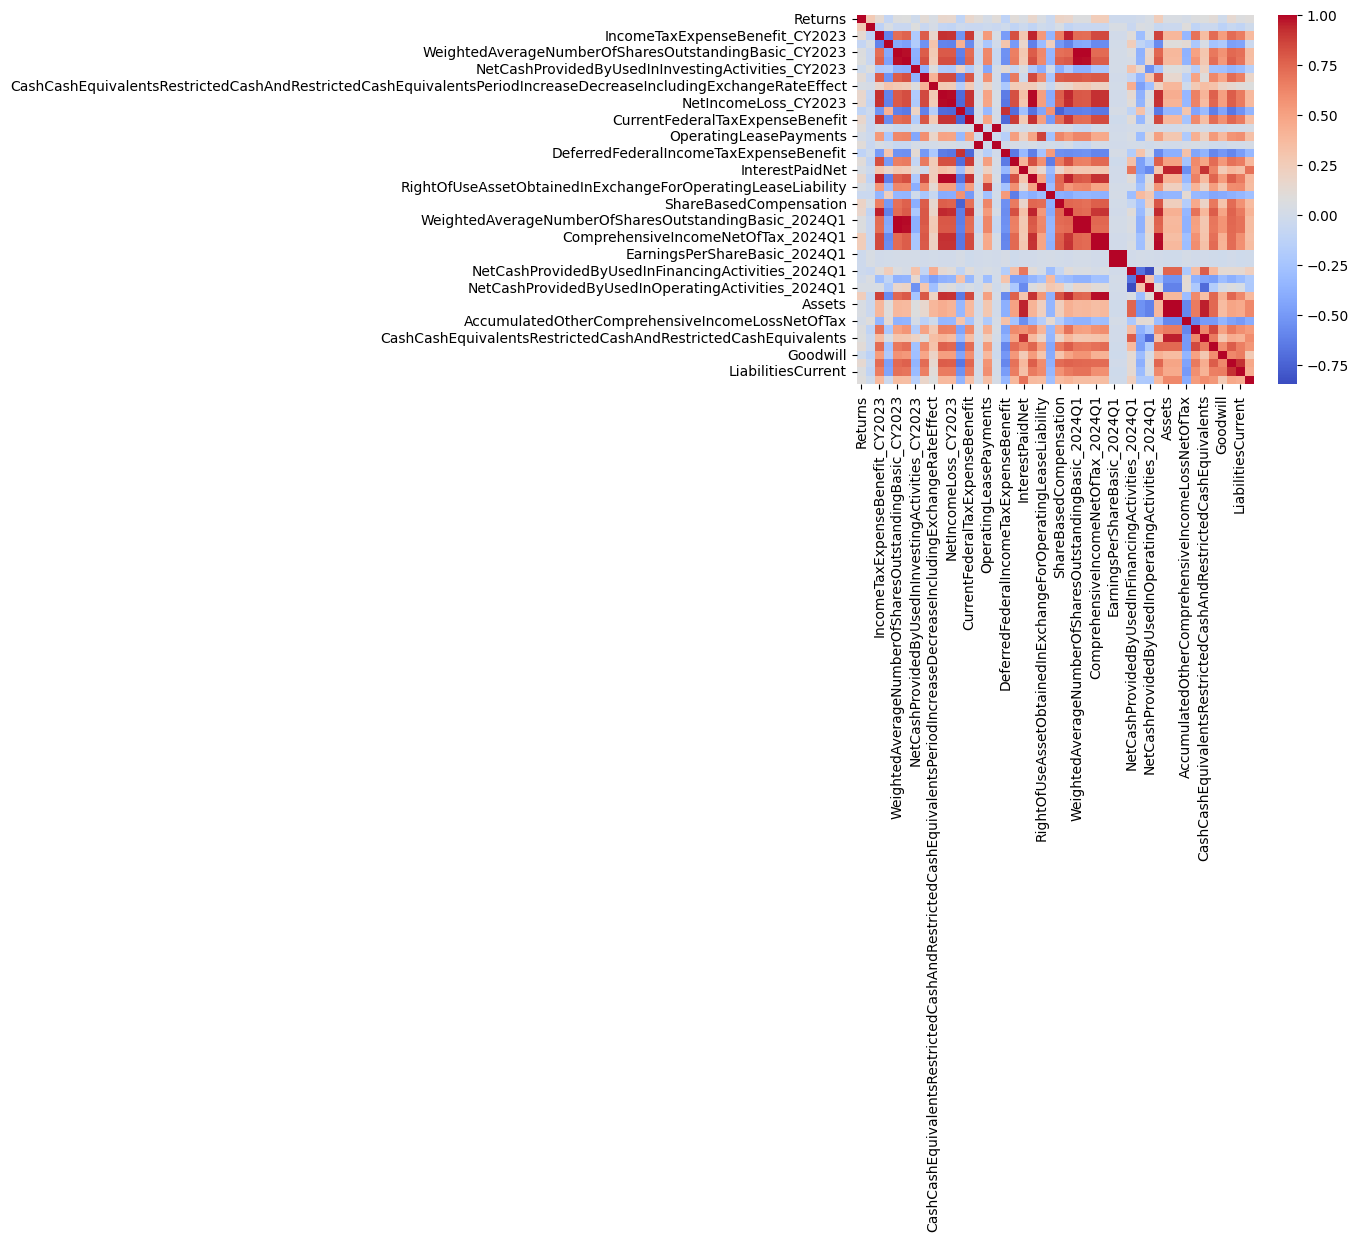

In [141]:
# Plot the correlation matrix
sns.heatmap(kmeans_data.corr(), annot=False, cmap='coolwarm', fmt=".2f");

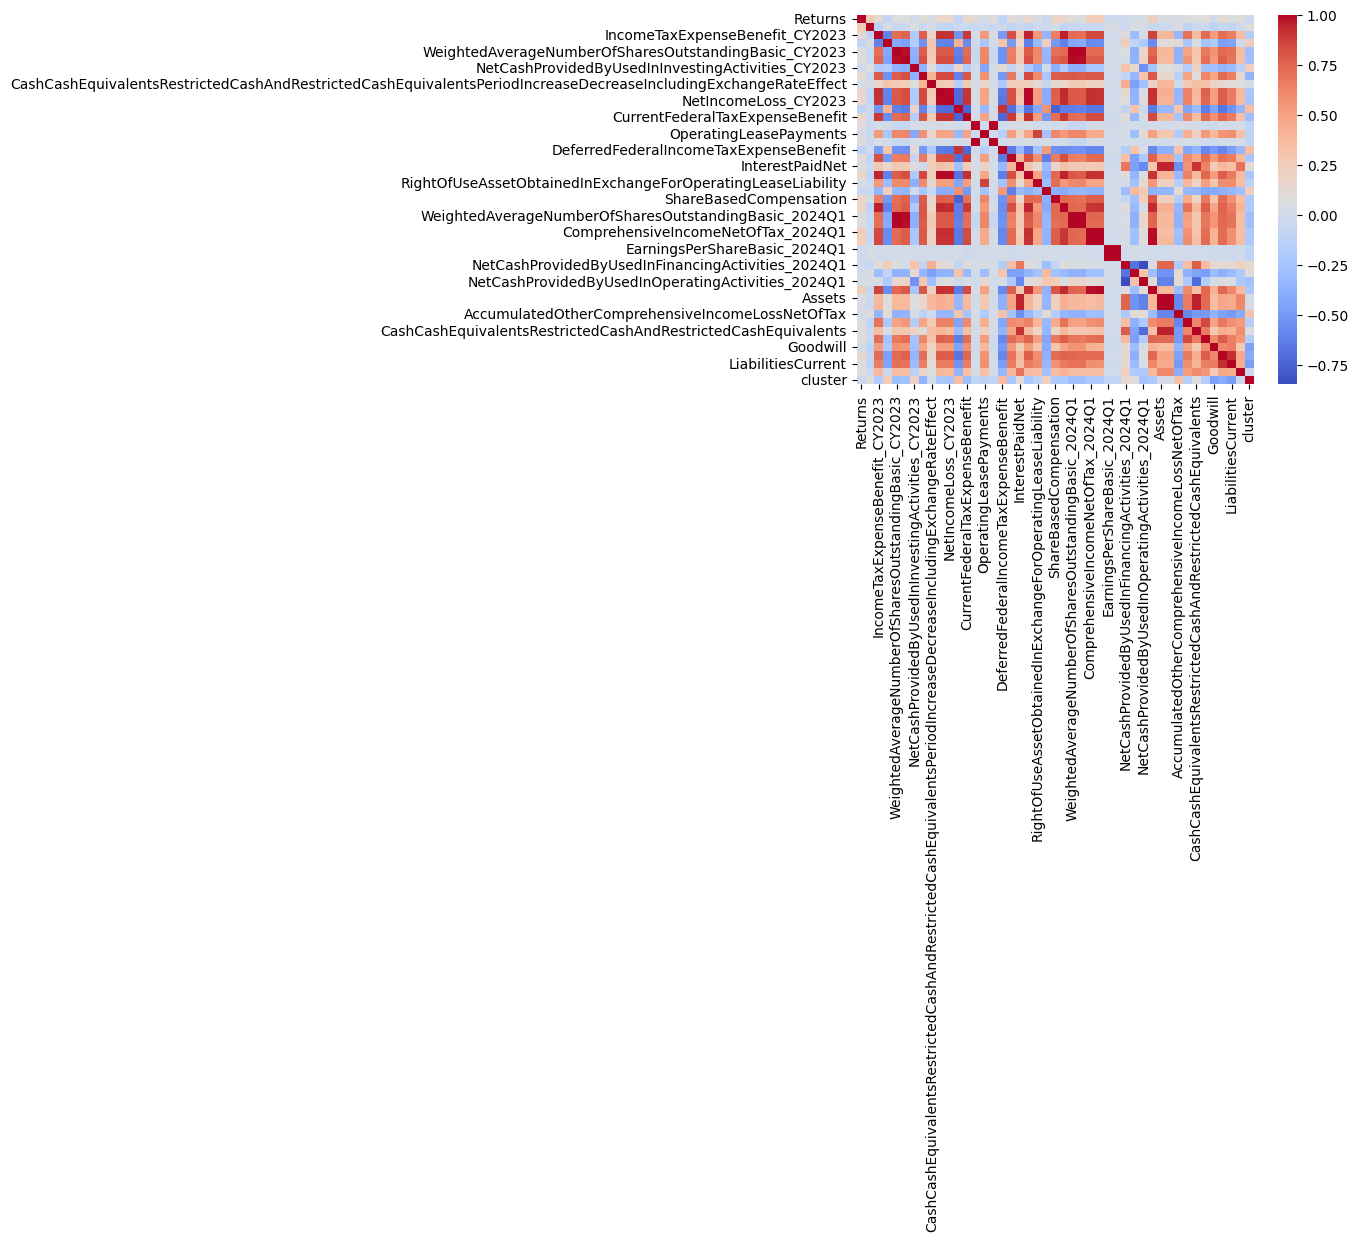

In [142]:
# Plot the correlation matrix
sns.heatmap(kmeans_data_raw.corr(), annot=False, cmap='coolwarm', fmt=".2f");

#### PCA

In [143]:
# Run PCA on the data
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(kmeans_data)
kmeans_data_pca = pd.DataFrame(data = principalComponents, columns = [f"PC{i}" for i in range(1, 11)], index=kmeans_data.index)
explained_variance_ratio = pca.explained_variance_ratio_

Variance explained by the first principal component: 45.56%
Variance explained by the second principal component: 13.05%
explained_variance_ratio: [0.45564699 0.13048872 0.05254357 0.04561715 0.04439522 0.03878076
 0.03184793 0.03107458 0.02745594 0.02133049]


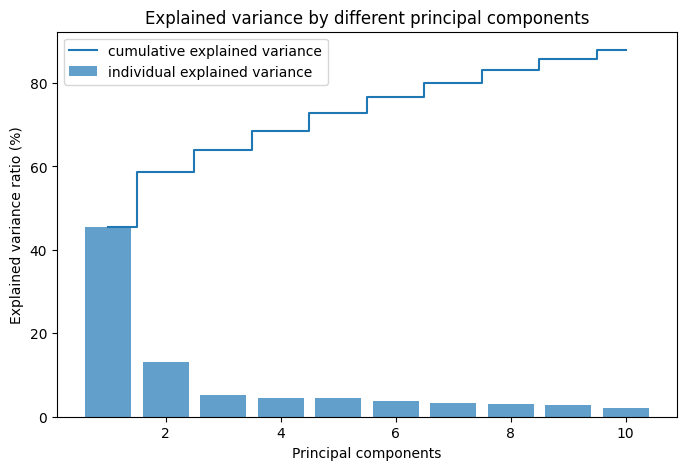

In [144]:
# Print the variance explained by the first and second components
print("Variance explained by the first principal component: {:.2f}%".format(explained_variance_ratio[0] * 100))
print("Variance explained by the second principal component: {:.2f}%".format(explained_variance_ratio[1] * 100))
print(f"explained_variance_ratio: {explained_variance_ratio}")

# Plotting the explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), explained_variance_ratio * 100, alpha=0.7, align='center', label='individual explained variance')
plt.step(range(1, 11), np.cumsum(explained_variance_ratio) * 100, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio (%)')
plt.xlabel('Principal components')
plt.title('Explained variance by different principal components')
plt.legend(loc='best')
plt.show()

In [145]:
# PC components of the data after PCA transformation
loading_df = pd.DataFrame(pca.components_, columns=kmeans_data.columns, index=[f"PC{i}" for i in range(1, 11)])
loading_df

Returns  Variance  IncomeTaxExpenseBenefit_CY2023  \
PC1      0.03     -0.02                            0.20   
PC2     -0.03     -0.01                           -0.06   
PC3      0.18      0.02                            0.11   
PC4     -0.00      0.06                            0.02   
PC5      0.03     -0.08                           -0.02   
PC6     -0.01     -0.08                            0.07   
PC7      0.48      0.60                           -0.16   
PC8      0.34      0.14                            0.12   
PC9     -0.10     -0.02                            0.07   
PC10     0.02      0.43                           -0.05   

      NetCashProvidedByUsedInFinancingActivities_CY2023  \
PC1                                               -0.11   
PC2                                                0.19   
PC3                                               -0.26   
PC4                                               -0.05   
PC5                                                0.17   
PC6                                               -0.23   
PC7                                                0.12   
PC8                                                0.04   
PC9                                               -0.25   
PC10                                              -0.26   

      WeightedAverageNumberOfSharesOutstandingBasic_CY2023  \
PC1                                                0.19      
PC2                                               -0.08      
PC3                                               -0.16      
PC4                                               -0.01      
PC5                                                0.03      
PC6                                               -0.06      
PC7                                               -0.04      
PC8                                               -0.01      
PC9                                               -0.10      
PC10                                               0.26      

      WeightedAverageNumberOfDilutedSharesOutstanding_CY2023  \
PC1                                                0.20        
PC2                                               -0.09        
PC3                                               -0.14        
PC4                                               -0.00        
PC5                                                0.02        
PC6                                               -0.05        
PC7                                               -0.04        
PC8                                                0.02        
PC9                                               -0.09        
PC10                                               0.19        

      NetCashProvidedByUsedInInvestingActivities_CY2023  \
PC1                                               -0.06   
PC2                                                0.16   
PC3                                                0.36   
PC4                                                0.10   
PC5                                               -0.27   
PC6                                                0.03   
PC7                                               -0.14   
PC8                                                0.05   
PC9                                                0.14   
PC10                                               0.42   

      NetCashProvidedByUsedInOperatingActivities_CY2023  \
PC1                                                0.18   
PC2                                               -0.17   
PC3                                               -0.01   
PC4                                                0.01   
PC5                                                0.01   
PC6                                               -0.19   
PC7                                               -0.09   
PC8                                                0.09   
PC9                                               -0.06   
PC10                                               0.04   

      CashCashEqui

In [146]:

# Function to find the most influential features for each PC
def most_influential_features(loading_df, top_n=5):
    influential_features = {}
    for i in range(loading_df.shape[0]):
        component_name = f'PC{i+1}'
        sorted_loadings = loading_df.iloc[i].abs().sort_values(ascending=False)
        influential_features[component_name] = sorted_loadings.index[:top_n].tolist()
    return influential_features

# Get the most influential features for each PC
top_features = most_influential_features(loading_df, top_n=5)

# Print the most influential features
for pc, features in top_features.items():
    print(f"{pc}: {features}")

PC1: ['ComprehensiveIncomeNetOfTax_CY2023', 'NetIncomeLoss_CY2023', 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_CY2023', 'IncomeTaxExpenseBenefit_2024Q1', 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_2024Q1']
PC2: ['NetCashProvidedByUsedInFinancingActivities_2024Q1', 'NetCashProvidedByUsedInOperatingActivities_2024Q1', 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents', 'InterestPaidNet', 'LiabilitiesAndStockholdersEquity']
PC3: ['EarningsPerShareDiluted_CY2023', 'EarningsPerShareBasic_CY2023', 'NetCashProvidedByUsedInInvestingActivities_CY2023', 'OperatingLeasePayments', 'NetCashProvidedByUsedInFinancingActivities_CY2023']
PC4: ['EarningsPerShareDiluted_2024Q1', 'EarningsPerShareBasic_2024Q1', 'NetCashProvidedByUsedInInvestingActivities_CY2023', 'Variance', 'EarningsPerShareDiluted_CY2023']
PC5: ['EarningsPerShareBasic_CY2023', 'EarningsPerShareDiluted_CY2023', 'NetCashProvide

Cluster_ID
3             347
0              65
4               6
1               5
5               3
2               1
6               1
Name: count, dtype: int64

C:\Users\Anuvrat\AppData\Local\Temp\ipykernel_25292\1594815263.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(kmeans_data_pca.PC1[i], kmeans_data_pca.PC2[i], kmeans_data.index[i], size=6)


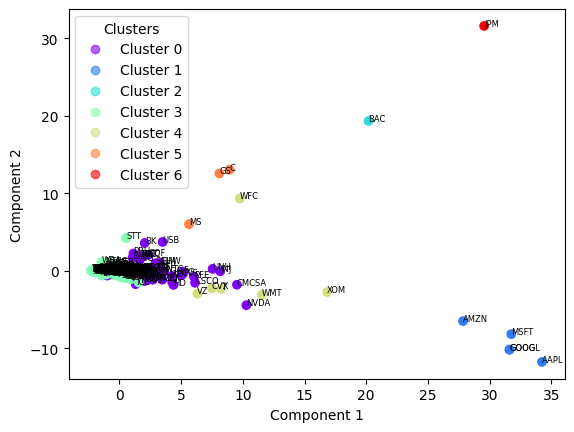

In [147]:
# Showing clusters by PC1 and PC2 axes
# Find number of stocks by cluster using kmeans.labels_
display(pd.DataFrame(kmeans.labels_, columns=["Cluster_ID"]).value_counts())

# Plot the data points with the cluster colors
scatter=plt.scatter(kmeans_data_pca.PC1,kmeans_data_pca.PC2, c = kmeans.labels_, cmap ="rainbow", label=kmeans.labels_)
# Create a legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = [f"Cluster {i}" for i in range(7)]
plt.legend(handles, legend_labels, title="Clusters")

# Add x and y axis labels
# Add labels to the points
for i in range(kmeans_data_pca.shape[0]):
    plt.text(kmeans_data_pca.PC1[i], kmeans_data_pca.PC2[i], kmeans_data.index[i], size=6)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#### Outlier removal

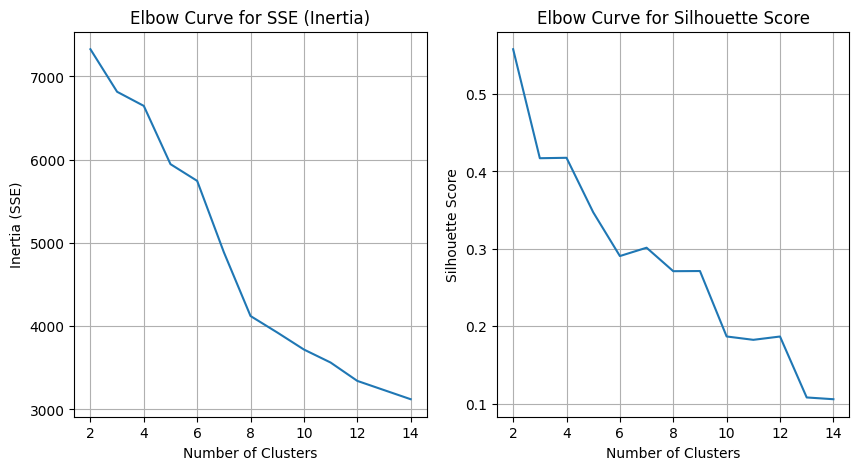

In [388]:
# Replotting elbow curve with outlier removed
# Setting a threshold for the PC1 value at 15 to remove outliers
kmeans_data_no_outliers = kmeans_data[kmeans_data_pca.PC1<15]
X = kmeans_data_no_outliers.values
sse = []
silhouette_scores = []
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k, random_state=seed)
    preds = kmeans.fit_predict(X)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters
    silhouette_scores.append(silhouette_score(X, preds)) #Silhouette score for each n_clusters

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) #Create a figure with 2 subplots
# Plot the SSE (inertia) for each number of clusters
ax[0].plot(range(2,15), sse)
ax[0].set_title("Elbow Curve for SSE (Inertia)")
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("Inertia (SSE)") # Lower inertia is better
ax[0].grid() # Show the grid
# Plot the Silhouette Score for each number of clusters
ax[1].plot(range(2,15), silhouette_scores)
ax[1].set_title("Elbow Curve for Silhouette Score")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Score") # Higher Silhouette Score is better
ax[1].grid() # Show the grid
# Add x and y axis labels
plt.show()

#### Select best model

In [389]:
# Select best model
kmeans = KMeans(n_clusters=4, random_state=seed).fit(kmeans_data_no_outliers)
centroids = kmeans.cluster_centers_

# Create a copy of kmeans_data_no_outliers to avoid SettingWithCopyWarning
kmeans_data_no_outliers = kmeans_data_no_outliers.copy()
kmeans_data_no_outliers.loc[:, 'cluster_no_outliers'] = kmeans.labels_

# Drop 'cluster_no_outliers' column from kmeans_data_raw if it exists
try:
    kmeans_data_raw.drop(columns='cluster_no_outliers', inplace=True)
except:
    pass
kmeans_data_raw=kmeans_data_raw.merge(kmeans_data_no_outliers['cluster_no_outliers'], left_index=True, right_index=True, how="outer")
#kmeans_data_raw.loc[kmeans_data_raw.cluster_no_outliers.isna(), "cluster_no_outliers"]=-1

# Replace all missing values with the -1
kmeans_data_raw.cluster_no_outliers = kmeans_data_raw.cluster_no_outliers.fillna(-1)

In [390]:
# Unique cluster values
display(sorted(kmeans_data_raw.cluster_no_outliers.unique()))
kmeans_data_raw.cluster_no_outliers.value_counts()

[-1.0, 0.0, 1.0, 2.0, 3.0]

cluster_no_outliers
2.00     332
0.00      69
1.00      18
-1.00      8
3.00       1
Name: count, dtype: int64

cluster_no_outliers
2.00     332
0.00      69
1.00      18
-1.00      8
3.00       1
Name: count, dtype: int64

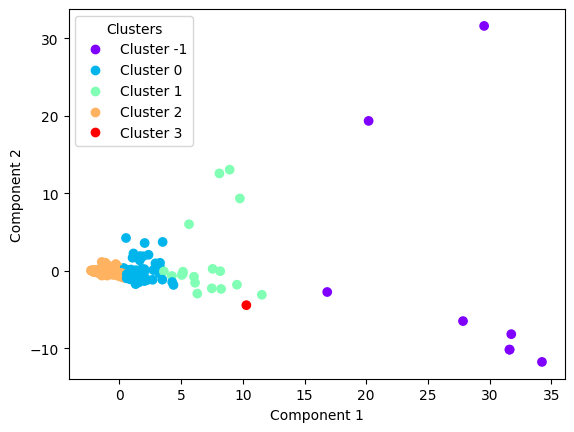

In [180]:
# Showing clusters by PC1 and PC2 axes
# Find number of stocks by cluster using kmeans.labels_
display(kmeans_data_raw.cluster_no_outliers.value_counts())

# Plot the data points with the cluster colors
scatter=plt.scatter(kmeans_data_pca.PC1, kmeans_data_pca.PC2, c = kmeans_data_raw.cluster_no_outliers, cmap ="rainbow", label=kmeans_data_raw.cluster_no_outliers)
# Create a legend
handles, labels = scatter.legend_elements(prop="colors", alpha=1.0)
legend_labels = [f"Cluster {int(i)}" for i in range(-1, 4)]
plt.legend(handles, legend_labels, title="Clusters")

# Add x and y axis labels
# Add labels to the points
#for i in range(kmeans_data_pca.shape[0]):
#    plt.text(kmeans_data_pca.PC1[i], kmeans_data_pca.PC2[i], kmeans_data.index[i], size=6)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
# Cut off x-axis at 15
#plt.xlim(-1, 15)
plt.show()

In [154]:
# Create a dictionary of the predicted clusters for each stock
dict_predicted_clusters_aggregates=dict(zip(kmeans_data_raw.index, kmeans_data_raw.cluster_no_outliers))

### Evaluations metrics

In [155]:
# Calculate Fowlkes Mallows Score (Mathematically, square root of the product of Precision and Recall)
print(f"fowlkes_mallows_score = {fowlkes_mallows_score(kmeans_data_raw.cluster_no_outliers, kmeans_data_raw.cluster):.2f}")

# A high score close to 1 indicates close alignment in the clustering results

fowlkes_mallows_score = 0.94


In [156]:
# Definitions of several clustering metrics taken from https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
# More details at https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2

In [157]:
# Calculate Calinski Harabasz Score (Variance Ratio Criterion)
# It is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters
# The higher the score, the better the performances of the clustering algorithm
print(f"calinski_harabasz_score = {calinski_harabasz_score(kmeans_data, kmeans_data_raw.cluster_no_outliers):.2f}")

# A value of 89.30 indicates that the clusters are well separated

calinski_harabasz_score = 89.30


In [158]:
# Calculate Davies Bouldin Score
# This index signifies the average ‘similarity’ between clusters, where the similarity is a measure 
# that compares the distance between clusters with the size of the clusters themselves.
# A lower Davies-Bouldin index relates to a model with better separation between the clusters.
print(
    f"davies_bouldin_score = {davies_bouldin_score(kmeans_data, kmeans_data_raw.cluster_no_outliers):.2f}"
)

# A value of 1.74 indicates that the clusters are well separated

davies_bouldin_score = 1.74


In [159]:
# Calculate Hopkins Statistic
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

# Calculate Hopkins Statistic
print(f"Hopkins statistics={hopkins(kmeans_data_no_outliers):.2f}")

# From ChatGPT:
# The Hopkins Statistic ranges from 0 to 1:
# Values close to 0 indicate that the data is highly clustered.
# Values close to 1 suggest that the data is uniformly distributed (i.e., no meaningful clusters).
# Values around 0.5 suggest a random distribution, indicating no clustering tendency.

# A Hopkins Statistic value close to 1 indicates that the data is uniformly distributed, with no meaningful clusters.

Hopkins statistics=0.94


### Interpretation of clusters

In [161]:
# Merging clusters with stocks
df_stock_clusters=pd.merge(df_stock, df_predicted_clusters, left_on='Symbol', right_on='Stock', how='inner').drop(columns='Stock')
print(df_predicted_clusters.shape, df_stock.shape, df_stock_clusters.shape)
df_stock_clusters.tail()
df_stock_clusters['Founded_clean'] = df_stock_clusters['Founded'].str.extract(r'(\d{4})').astype(float)

(432, 3) (503, 8) (432, 10)


In [162]:
df_stock_clusters['Cluster_TS'].value_counts()

Cluster_TS
3    155
4    124
2     74
0     59
1     20
Name: count, dtype: int64

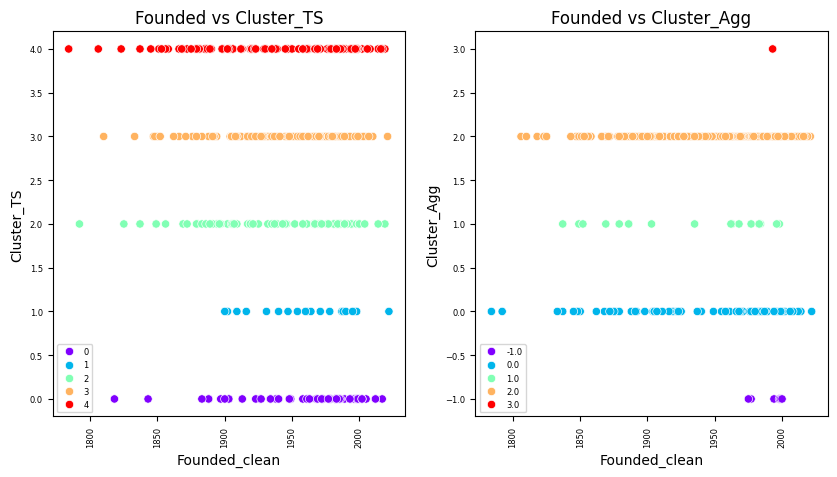

In [163]:
# Draw a scatterplot of Date added and Cluster_TS
# Draw a figure with 2 subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.scatterplot(data=df_stock_clusters, x='Founded_clean', y='Cluster_TS', hue='Cluster_TS', palette='rainbow', ax=ax[0])
ax[0].set_title('Founded vs Cluster_TS')
sns.scatterplot(data=df_stock_clusters, x='Founded_clean', y='Cluster_Agg', hue='Cluster_Agg', palette='rainbow', ax=ax[1])
ax[1].set_title('Founded vs Cluster_Agg')
# Make x-ticks smaller and vertical
ax[0].tick_params(axis='x', labelsize=6, rotation=90)
ax[1].tick_params(axis='x', labelsize=6, rotation=90)
# Make y-ticks smaller
ax[0].tick_params(axis='y', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
# Make legend smaller
ax[0].legend(fontsize=6, loc='lower left')
ax[1].legend(fontsize=6, loc='lower left')
plt.show()


In [209]:
# Summary of Sector and sub-industry
#df_stock_clusters[['GICS Sector', 'GICS Sub-Industry']].value_counts()[0:50]

In [210]:
# Create summary by Cluster_TS and GICS Sector and pivot it, then reset the index
df_summary_clusters_TS=df_stock_clusters.groupby(['Cluster_TS', 'GICS Sector']).size().reset_index(name='Count')
df_summary_clusters_TS_pivot=df_summary_clusters_TS.pivot(index='Cluster_TS', columns='GICS Sector', values='Count')
display(df_summary_clusters_TS_pivot)

df_summary_clusters_Agg=df_stock_clusters.groupby(['Cluster_Agg', 'GICS Sector']).size().reset_index(name='Count')
df_summary_clusters_Agg_pivot=df_summary_clusters_Agg.pivot(index='Cluster_Agg', columns='GICS Sector', values='Count')
display(df_summary_clusters_Agg_pivot)

GICS Sector  Communication Services  Consumer Discretionary  Consumer Staples  \
Cluster_TS                                                                      
0                              2.00                   10.00              5.00   
1                              1.00                    5.00              1.00   
2                              4.00                    3.00             13.00   
3                              5.00                   19.00              5.00   
4                              4.00                    7.00             10.00   

GICS Sector  Energy  Financials  Health Care  Industrials  \
Cluster_TS                                                  
0              3.00        5.00        10.00         7.00   
1              1.00        2.00         5.00         1.00   
2              3.00        7.00        15.00         4.00   
3              4.00       22.00        13.00        35.00   
4              6.00       29.00        13.00        17.00   

GICS Sector  Information Technology  Materials  Real Estate  Utilities  
Cluster_TS                                                              
0                             10.00       1.00         5.00       1.00  
1                              2.00       1.00          NaN       1.00  
2                               NaN       5.00        10.00      10.00  
3                             34.00       8.00         8.00       2.00  
4                              9.00       8.00         6.00      15.00

GICS Sector  Communication Services  Consumer Discretionary  Consumer Staples  \
Cluster_Agg                                                                     
-1.00                          2.00                    1.00               NaN   
0.00                           3.00                    7.00              5.00   
1.00                           3.00                    1.00              3.00   
2.00                           8.00                   35.00             25.00   
3.00                            NaN                     NaN               NaN   

GICS Sector  Energy  Financials  Health Care  Industrials  \
Cluster_Agg                                                 
-1.00          1.00        2.00          NaN          NaN   
0.00           2.00       21.00        12.00        10.00   
1.00           1.00        4.00         4.00          NaN   
2.00          13.00       38.00        39.00        54.00   
3.00            NaN         NaN          NaN          NaN   

GICS Sector  Information Technology  Materials  Real Estate  Utilities  
Cluster_Agg                                                             
-1.00                          2.00        NaN          NaN        NaN  
0.00                           6.00       1.00          NaN       2.00  
1.00                           2.00        NaN          NaN        NaN  
2.00                          42.00      22.00        29.00      27.00  
3.00                           1.00        NaN          NaN        NaN

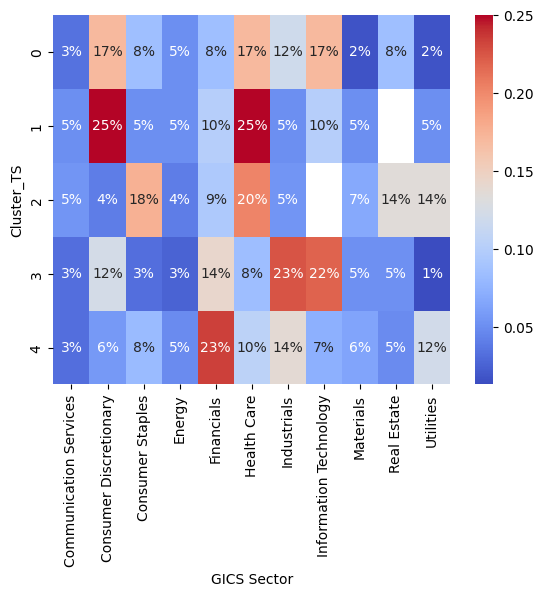

In [211]:
# Summary by Cluster_TS across Sectors
sns.heatmap(df_summary_clusters_TS_pivot.div(df_summary_clusters_TS_pivot.sum(axis=1), axis=0), annot=True, cmap='coolwarm', fmt=".0%");

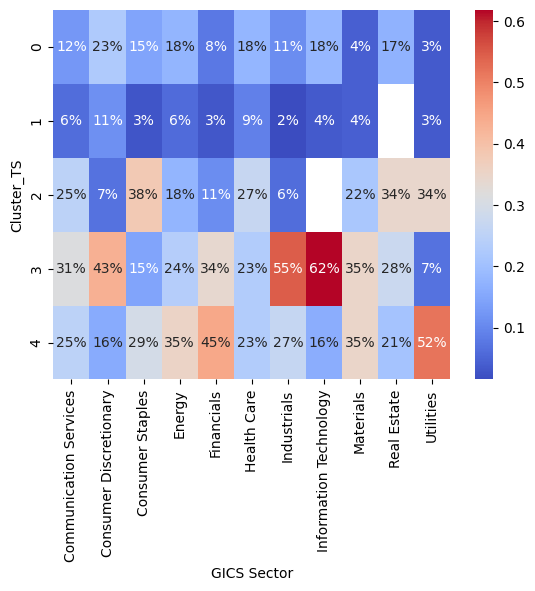

In [212]:
# Summary by Sector across Cluster_TS
sns.heatmap(df_summary_clusters_TS_pivot.div(df_summary_clusters_TS_pivot.sum(axis=0), axis=1), annot=True, cmap='coolwarm', fmt=".0%");

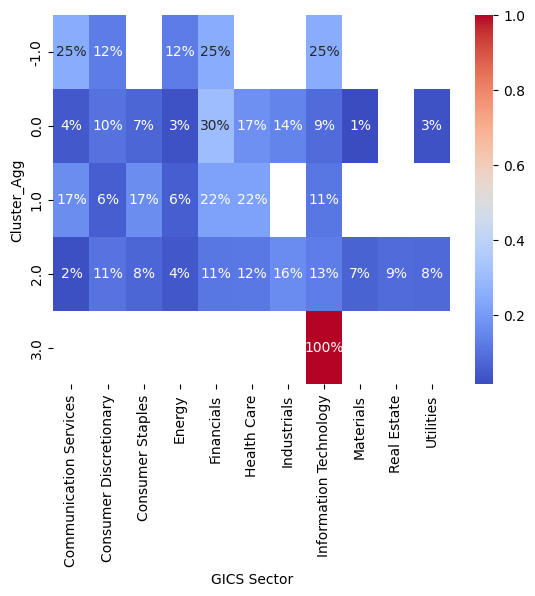

In [213]:
# Summary by Cluster_Agg across Sectors
sns.heatmap(df_summary_clusters_Agg_pivot.div(df_summary_clusters_Agg_pivot.sum(axis=1), axis=0), annot=True, cmap='coolwarm', fmt=".0%");

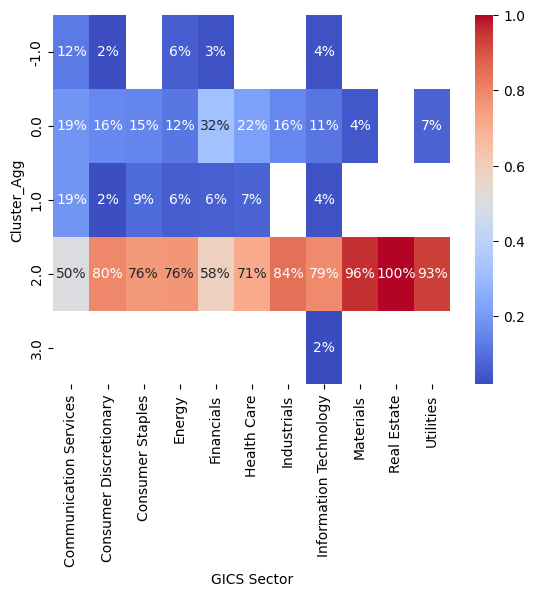

In [214]:
# Summary by Sector across Cluster_Agg
sns.heatmap(df_summary_clusters_Agg_pivot.div(df_summary_clusters_Agg_pivot.sum(axis=0), axis=1), annot=True, cmap='coolwarm', fmt=".0%");

#### Median and Mean values of features by cluster

In [215]:
kmeans_data_raw.cluster_no_outliers.value_counts()

cluster_no_outliers
2.00     332
0.00      69
1.00      18
-1.00      8
3.00       1
Name: count, dtype: int64

In [216]:
# Set the options to display float with 2 decimal places instead of scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [217]:
print("Mean values of the clusters:")
kmeans_data_raw.groupby('cluster_no_outliers').mean().T

Mean values of the clusters:


cluster_no_outliers                                           -1.00  \
Returns                                                        0.39   
Variance                                                       0.26   
IncomeTaxExpenseBenefit_CY2023                       11746375000.00   
NetCashProvidedByUsedInFinancingActivities_CY2023   -34876375000.00   
WeightedAverageNumberOfSharesOutstandingBasic_C...    7920195985.00   
WeightedAverageNumberOfDilutedSharesOutstanding...    9241791376.25   
NetCashProvidedByUsedInInvestingActivities_CY2023   -13744000000.00   
NetCashProvidedByUsedInOperatingActivities_CY2023    74986000000.00   
CashCashEquivalentsRestrictedCashAndRestrictedC...   26524750000.00   
ComprehensiveIncomeNetOfTax_CY2023                   59604500000.00   
NetIncomeLoss_CY2023                                 57431000000.00   
DeferredIncomeTaxExpenseBenefit                      -4967238750.00   
CurrentFederalTaxExpenseBenefit                       7934480000.00   
EarningsPerShareBasic_CY2023                                   7.34   
OperatingLeasePayments                                3495477500.00   
EarningsPerShareDiluted_CY2023                                 7.31   
DeferredFederalIncomeTaxExpenseBenefit               -2877793750.00   
CurrentStateAndLocalTaxExpenseBenefit                 1716563750.00   
InterestPaidNet                                      21612385000.00   
IncomeLossFromContinuingOperationsBeforeIncomeT...   68419800000.00   
RightOfUseAssetObtainedInExchangeForOperatingLe...    3772005125.00   
DeferredStateAndLocalIncomeTaxExpenseBenefit          -361207500.00   
ShareBasedCompensation                               12171480500.00   
IncomeTaxExpenseBenefit_2024Q1                        3656000000.00   
WeightedAverageNumberOfSharesOutstandingBasic_2...    8104525850.00   
WeightedAverageNumberOfDilutedSharesOutstanding...    7989723250.00   
ComprehensiveIncomeNetOfTax_2024Q1                   15937250000.00   
NetIncomeLoss_2024Q1                                 16455375000.00   
EarningsPerShareBasic_2024Q1                                   2.07   
EarningsPerShareDiluted_2024Q1                                 2.06   
NetCashProvidedByUsedInFinancingActivities_2024Q1    17239145000.00   
NetCashProvidedByUsedInInvestingActivities_2024Q1   -21676462500.00   
NetCashProvidedByUsedInOperatingActivities_2024Q1    -3346325000.00   
IncomeLossFromContinuingOperationsBeforeIncomeT...   20903607500.00   
Assets                                             1238725375000.00   
LiabilitiesAndStockholdersEquity                   1238725375000.00   
AccumulatedOtherComprehensiveIncomeLossNetOfTax      -8817000000.00   
RetainedEarningsAccumulatedDeficit                  219622125000.00   
CashCashEquivalentsRestrictedCashAndRestrictedC...  135592750000.00   
StockholdersEquity                                  245641750000.00   
Goodwill                                             52302257500.00   
AssetsCurrent                                       135625076250.00   
LiabilitiesCurrent                                   95601742500.00   
CashAndCashEquivalentsAtCarryingValue                36579485000.00   
cluster                                                        2.12   

cluster_no_outliers                                          0.00   \
Returns                                                       0.19   
Variance                                                      0.24   
IncomeTaxExpenseBenefit_CY2023                       1332090014.49   
NetCashProvidedByUsedInFinancingActivities_CY2023   -6864273679.57   
WeightedAverageNumberOfSharesOutstandingBasic_C...    884182556.59   
WeightedAverageNumberOfDilutedSharesOutstanding...    877179328.32   
NetCashProvidedByUsedInInvestingActivities_CY2023   -3239933902.32   
NetCashProvidedByUsedInOperatingActivities_CY2023    9336577131.30   
CashCashEquivalentsRestrictedCashAndRestrictedC...   -528265806.96   
ComprehensiveIncomeNetOfTax_CY202

In [218]:
print("Median values of the clusters:")
kmeans_data_raw.groupby('cluster_no_outliers').median().T

Median values of the clusters:


cluster_no_outliers                                          -1.00  \
Returns                                                       0.40   
Variance                                                      0.24   
IncomeTaxExpenseBenefit_CY2023                      11991000000.00   
NetCashProvidedByUsedInFinancingActivities_CY2023  -39116000000.00   
WeightedAverageNumberOfSharesOutstandingBasic_C...   7435034220.00   
WeightedAverageNumberOfDilutedSharesOutstanding...   9286250000.00   
NetCashProvidedByUsedInInvestingActivities_CY2023  -24871500000.00   
NetCashProvidedByUsedInOperatingActivities_CY2023   86264000000.00   
CashCashEquivalentsRestrictedCashAndRestrictedC...  12698500000.00   
ComprehensiveIncomeNetOfTax_CY2023                  63573000000.00   
NetIncomeLoss_CY2023                                60956500000.00   
DeferredIncomeTaxExpenseBenefit                     -5967500000.00   
CurrentFederalTaxExpenseBenefit                      9209000000.00   
EarningsPerShareBasic_CY2023                                  6.00   
OperatingLeasePayments                               2813910000.00   
EarningsPerShareDiluted_CY2023                                5.96   
DeferredFederalIncomeTaxExpenseBenefit              -3502940000.00   
CurrentStateAndLocalTaxExpenseBenefit                1750020000.00   
InterestPaidNet                                      4846685000.00   
IncomeLossFromContinuingOperationsBeforeIncomeT...  73664500000.00   
RightOfUseAssetObtainedInExchangeForOperatingLe...   2702043000.00   
DeferredStateAndLocalIncomeTaxExpenseBenefit         -399880000.00   
ShareBasedCompensation                              10222000000.00   
IncomeTaxExpenseBenefit_2024Q1                       4148000000.00   
WeightedAverageNumberOfSharesOutstandingBasic_2...   8167062700.00   
WeightedAverageNumberOfDilutedSharesOutstanding...   7539438000.00   
ComprehensiveIncomeNetOfTax_2024Q1                  16838000000.00   
NetIncomeLoss_2024Q1                                17679000000.00   
EarningsPerShareBasic_2024Q1                                  1.91   
EarningsPerShareDiluted_2024Q1                                1.89   
NetCashProvidedByUsedInFinancingActivities_2024Q1   -6210420000.00   
NetCashProvidedByUsedInInvestingActivities_2024Q1   -9632000000.00   
NetCashProvidedByUsedInOperatingActivities_2024Q1   19324700000.00   
IncomeLossFromContinuingOperationsBeforeIncomeT...  22808430000.00   
Assets                                             445812500000.00   
LiabilitiesAndStockholdersEquity                   445812500000.00   
AccumulatedOtherComprehensiveIncomeLossNetOfTax     -7197500000.00   
RetainedEarningsAccumulatedDeficit                 219770000000.00   
CashCashEquivalentsRestrictedCashAndRestrictedC...  33635000000.00   
StockholdersEquity                                 272998000000.00   
Goodwill                                            48231030000.00   
AssetsCurrent                                      137798000000.00   
LiabilitiesCurrent                                  81467155000.00   
CashAndCashEquivalentsAtCarryingValue               33007500000.00   
cluster                                                       1.00   

cluster_no_outliers                                         0.00   \
Returns                                                      0.15   
Variance                                                     0.22   
IncomeTaxExpenseBenefit_CY2023                      1162000000.00   
NetCashProvidedByUsedInFinancingActivities_CY2023  -5487000000.00   
WeightedAverageNumberOfSharesOutstandingBasic_C...   663000000.00   
WeightedAverageNumberOfDilutedSharesOutstanding...   638591616.00   
NetCashProvidedByUsedInInvestingActivities_CY2023  -3184500000.00   
NetCashProvidedByUsedInOperatingActivities_CY2023   8471000000.00   
CashCashEquivalentsRestrictedCashAndRestrictedC...   335000000.00   
ComprehensiveIncomeNetOfTax_CY2023                  5602000000.00   
NetIncomeLoss_CY2023

In [219]:
kmeans_data_raw.cluster_no_outliers.value_counts()

cluster_no_outliers
2.00     332
0.00      69
1.00      18
-1.00      8
3.00       1
Name: count, dtype: int64

In [220]:
df_stock_clusters[df_stock_clusters.Cluster_Agg==0]

Symbol                   Security             GICS Sector  \
1      ABT                     Abbott             Health Care   
2      ACN                  Accenture  Information Technology   
6      AFL                      Aflac              Financials   
17      MO                     Altria        Consumer Staples   
22     AXP           American Express              Financials   
..     ...                        ...                     ...   
397    UPS      United Parcel Service             Industrials   
401    VLO              Valero Energy                  Energy   
408      V                  Visa Inc.              Financials   
415    DIS  Walt Disney Company (The)  Communication Services   
416    WBD     Warner Bros. Discovery  Communication Services   

                             GICS Sub-Industry      Headquarters Location  \
1                        Health Care Equipment    North Chicago, Illinois   
2               IT Consulting & Other Services            Dublin, Ireland   
6                      Life & Health Insurance          Columbus, Georgia   
17                                     Tobacco         Richmond, Virginia   
22                            Consumer Finance    New York City, New York   
..                                         ...                        ...   
397                    Air Freight & Logistics     Sandy Springs, Georgia   
401             Oil & Gas Refining & Marketing         San Antonio, Texas   
408  Transaction & Payment Processing Services  San Francisco, California   
415                     Movies & Entertainment        Burbank, California   
416                               Broadcasting    New York City, New York   

     Date added         CIK                   Founded  Cluster_Agg  \
1    1957-03-04  0000001800                      1888         0.00   
2    2011-07-06  0001467373                      1989         0.00   
6    1999-05-28  0000004977                      1955         0.00   
17   1957-03-04  0000764180                      1985         0.00   
22   1976-06-30  0000004962                      1850         0.00   
..          ...         ...                       ...          ...   
397  2002-07-22  0001090727                      1907         0.00   
401  2002-12-20  0001035002                      1980         0.00   
408  2009-12-21  0001403161                      1958         0.00   
415  1976-06-30  0001744489                      1923         0.00   
416  2022-04-11  0001437107  2022 (Warner Bros. 1923)         0.00   

     Cluster_TS  Founded_clean  
1             0        1888.00  
2             0        1989.00  
6             3        1955.00  
17            4        1985.00  
22            3        1850.00  
..          ...            ...  
397           2        1907.00  
401           3        1980.00  
408           3        1958.00  
415           4        1923.00  
416           1        2022.00  

[69 rows x 11 columns]

#### Assign cluster definitions

<b> Timeseries clusters: Created with data over the last one year.</b>
<ul> 
<li>Cluster 0 - Flat with a peak</li> 
<li>Cluster 1  - Fluctuating decliners</li> 
<li>Cluster 2 - Stable decliners</li> 
<li>Cluster 3 - Fast risers</li> 
<li>Cluster 4 - Recovering</li> 
</ul>

<b> Aggregate clusters: </b>
<ul>
<li>Cluster -1 - Behemoths </li> 
<li>Cluster 0 - Low cash flow, high return</li> 
<li>Cluster 1  - Low earning and returns</li> 
<li>Cluster 2 - Smaller bulk</li> 
<li>Cluster 3 - Outlier. Closest to cluster 1 and -1</li> 
</ul>

In [224]:
dict_cluster_def_ts = {0: 'Flat with a peak', 1: 'Fluctuating decliners', 2: 'Stable decliners', 3: 'Fast risers', 4: 'Recovering'}
dict_cluster_def_agg = {-1: 'Behemoths', 0: 'Low cash flow, high return', 1:'Low earning and returns',  2: 'Smaller bulk', 3: 'Outlier. Closest to cluster 1 and -1'}

### Combine results from TS learn and K Means approaches

In [225]:
# Create a dataset with dict_predicted_clusters_aggregates
df_predicted_clusters_aggregates=pd.DataFrame(dict_predicted_clusters_aggregates.items(), columns=['Stock', 'Cluster_Agg'])
# Create a dataset with dict_predicted_clusters_ts
df_predicted_clusters_ts=pd.DataFrame(dict_predicted_clusters_ts.items(), columns=['Stock', 'Cluster_TS'])

# Merge the two datasets
df_predicted_clusters=df_predicted_clusters_aggregates.merge(df_predicted_clusters_ts, on='Stock', how='outer')

# Save the dataset as a pickle file
df_predicted_clusters.to_pickle(data_folder + 'df_predicted_clusters_unsupervised.pkl')

# Create a cross-tabulation of the clusters
cross_tab_clusters=pd.crosstab(df_predicted_clusters.Cluster_Agg, df_predicted_clusters.Cluster_TS)
# Apply dictionary dict_cluster_def_agg on values of cross_tab_clusters.index
cross_tab_clusters.index = cross_tab_clusters.index.map(dict_cluster_def_agg)
# Apply dictionary dict_cluster_def_ts on values of cross_tab_clusters.columns
cross_tab_clusters.columns = cross_tab_clusters.columns.map(dict_cluster_def_ts)
cross_tab_clusters

Cluster_TS                            Flat with a peak  Fluctuating decliners  \
Cluster_Agg                                                                     
Behemoths                                            0                      0   
Low cash flow, high return                           4                      2   
Low earning and returns                              5                      1   
Smaller bulk                                        48                     17   
Outlier. Closest to cluster 1 and -1                 0                      0   

Cluster_TS                            Stable decliners  Fast risers  \
Cluster_Agg                                                           
Behemoths                                            0            6   
Low cash flow, high return                           6           32   
Low earning and returns                              4            2   
Smaller bulk                                        63          113   
Outlier. Closest to cluster 1 and -1                 0            1   

Cluster_TS                            Recovering  
Cluster_Agg                                       
Behemoths                                      2  
Low cash flow, high return                    25  
Low earning and returns                        6  
Smaller bulk                                  91  
Outlier. Closest to cluster 1 and -1           0

### Feature importance

#### Using drop-1 method

In [409]:
dist = {}
for feature in kmeans.feature_names_in_:
    df_fi_drop_one = kmeans_data_no_outliers.drop(columns=[feature, 'cluster_no_outliers'])
    kmeans_drop_one = KMeans(n_clusters=4, random_state=seed).fit(df_fi_drop_one)
    

    # Original centroids
    original_centroids = kmeans.cluster_centers_

    # Remove the dropped feature values from the original centroids
    original_centroids = np.delete(original_centroids, np.where(kmeans.feature_names_in_ == feature), axis=1)

    # New centroids
    new_centroids = kmeans_drop_one.cluster_centers_

    # Calculate euclidean distance between the original centroids and the new centroids
    dist[feature] = np.linalg.norm(original_centroids - new_centroids)

df_dist=pd.DataFrame(dist, index=['importance_drop_one']).T.sort_values(by='importance_drop_one', ascending=False)
df_dist['rank_importance_drop_one']=df_dist['importance_drop_one'].rank(ascending=False)
df_dist.head()

importance_drop_one  \
EarningsPerShareDiluted_2024Q1                              37.04   
EarningsPerShareBasic_2024Q1                                37.04   
Goodwill                                                    36.62   
DeferredStateAndLocalIncomeTaxExpenseBenefit                35.97   
LiabilitiesCurrent                                          34.90   

                                              rank_importance_drop_one  
EarningsPerShareDiluted_2024Q1                                    1.00  
EarningsPerShareBasic_2024Q1                                      2.00  
Goodwill                                                          3.00  
DeferredStateAndLocalIncomeTaxExpenseBenefit                      4.00  
LiabilitiesCurrent                                                5.00

#### Using multi-class classification

##### Defining training and testing datasets

In [273]:
df_fi_X = kmeans_data_no_outliers[kmeans_data_no_outliers.cluster_no_outliers!=3].drop(columns='cluster_no_outliers')
df_fi_y = kmeans_data_no_outliers[kmeans_data_no_outliers.cluster_no_outliers!=3]['cluster_no_outliers']

In [274]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(df_fi_X, df_fi_y, random_state = seed)

##### Using LR

precision=0.9525901875901875
recall=0.9428571428571428
f1=0.9465859564164649


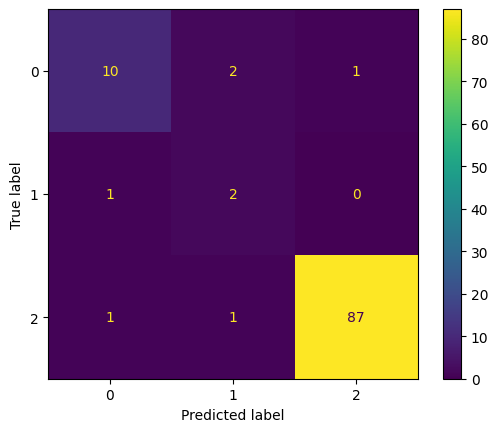

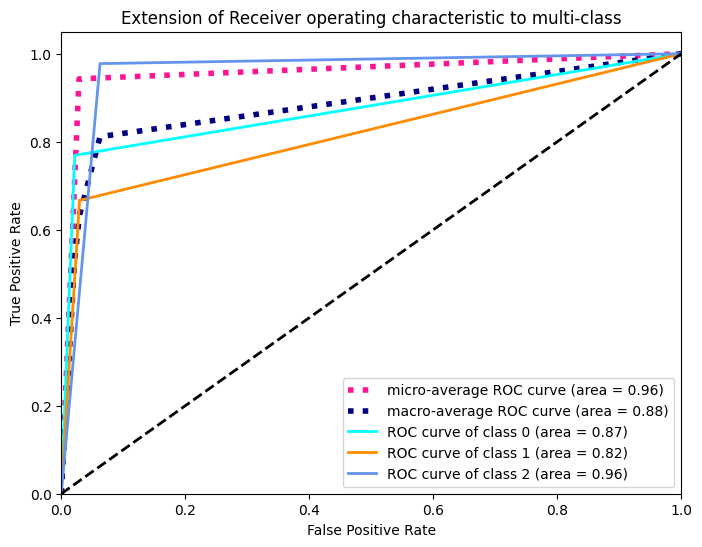

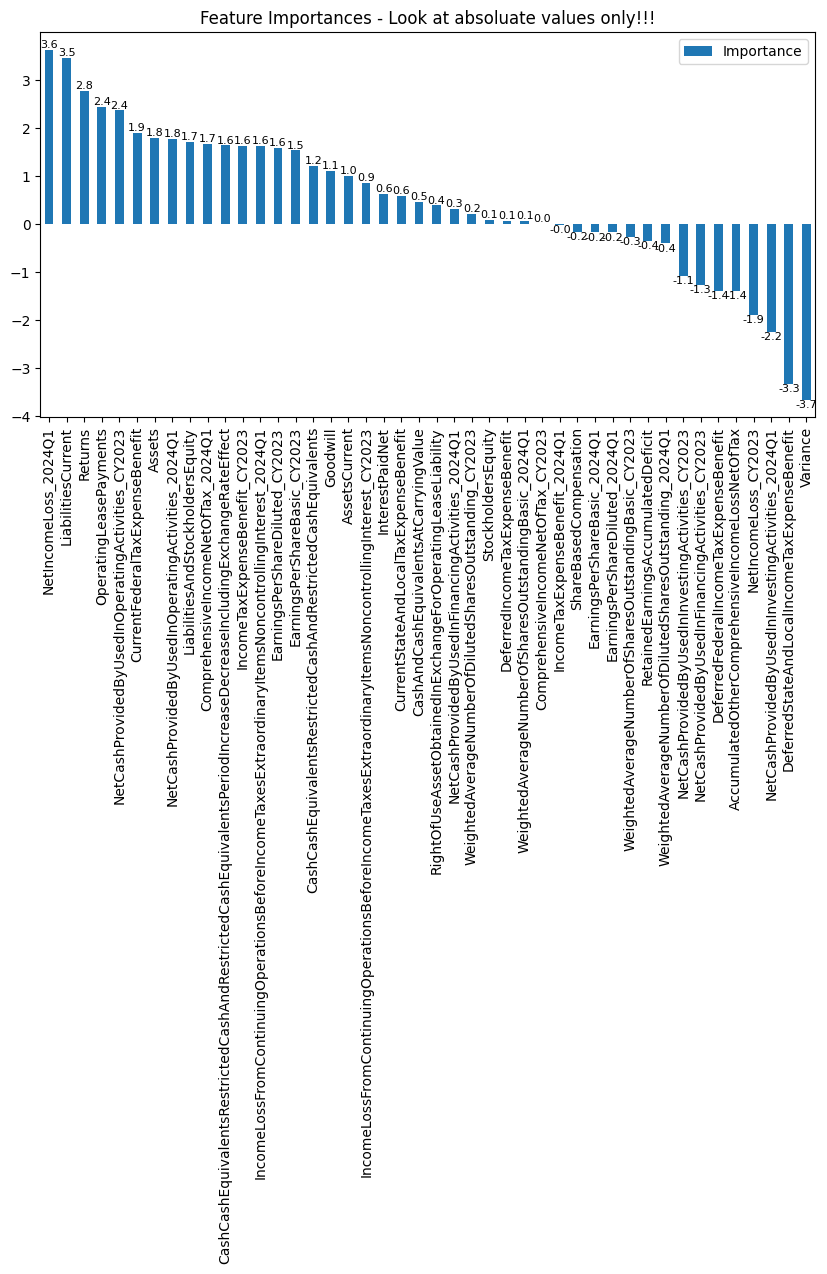

In [334]:
# Define and fit the logistic regression model
clf_lr = LogisticRegression(C=1e10, random_state=0, penalty='l2').fit(X_train, y_train)

# Display the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(clf_lr, X_test, y_test)


# Predict the test set results
y_test_pred=clf_lr.predict(X_test)
print(f"precision={precision_score(y_test, y_test_pred, average='weighted')}")
print(f"recall={recall_score(y_test, y_test_pred, average='weighted')}") 
print(f"f1={f1_score(y_test, y_test_pred, average='weighted')}")


# Draw roc curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_test_pred_bin = label_binarize(y_test_pred, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Feature importance
# Get the feature importances from the classifier
feature_importances_lr = clf_lr.coef_[0]
# Create a DataFrame with the feature importances
df_feature_importances_lr = pd.DataFrame(feature_importances_lr, index=X_train.columns, columns=['Importance'])
# Sort the DataFrame by the feature importances
df_feature_importances_lr = df_feature_importances_lr.sort_values(by='Importance', ascending=False)

# Display the feature importances (Both negative and positive)
df_feature_importances_lr.plot(kind='bar', figsize=(10, 5))
# Display the labels for the importance values
for i, v in enumerate(df_feature_importances_lr['Importance']):
    if v>0:
        plt.text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8)
    else:
        plt.text(i, v, f"{v:.1f}", ha='center', va='top', fontsize=8)

plt.title('Feature Importances - Look at absoluate values only!!!')
plt.show()

##### Using RF

precision=0.937037037037037
recall= 0.9523809523809523
f1= 0.9418272587627426


c:\Users\Anuvrat\OneDrive\Documents\siads\milestone2\venv_milestone2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


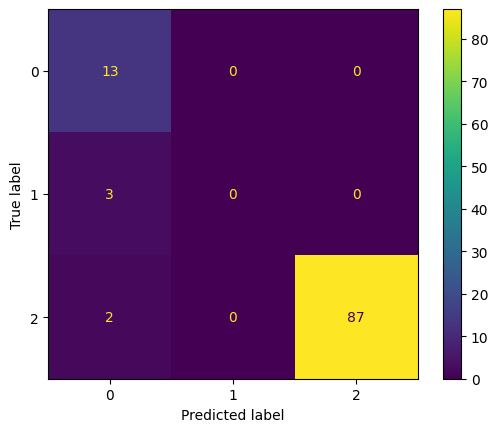

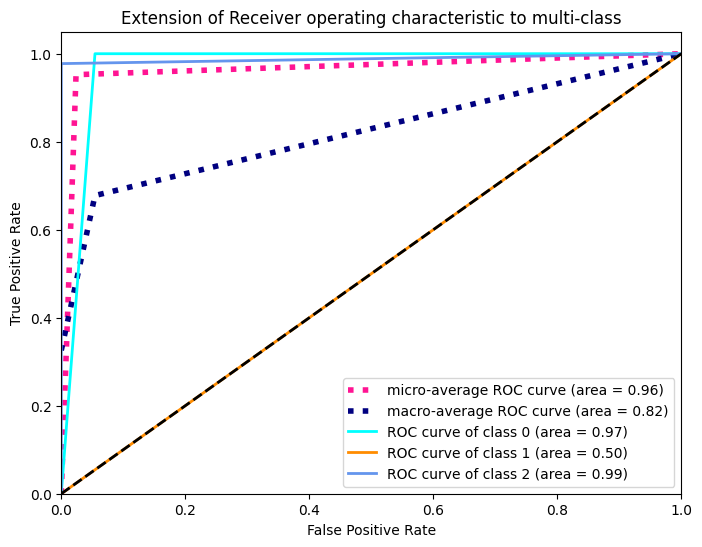

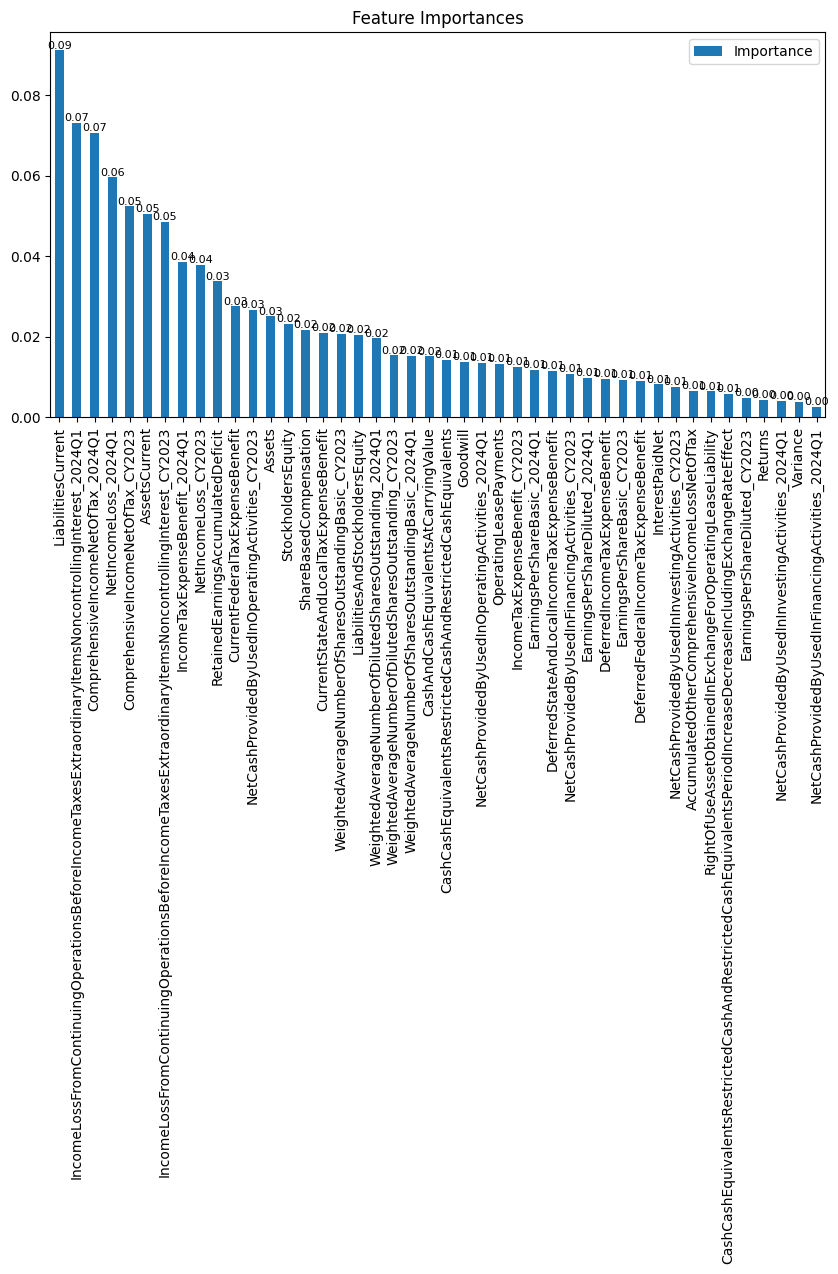

In [335]:
# Create random forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5, random_state=seed)
# Fit the classifier
clf_rf.fit(X_train, y_train)
# Predict the test set results
y_test_pred_rf = clf_rf.predict(X_test)
# Display the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(clf_rf, X_test, y_test)

# Predicting the test set results
y_test_pred_rf = clf_rf.predict(X_test)
print(f"precision={precision_score(y_test, y_test_pred_rf, average='weighted')}")
print(f"recall= {recall_score(y_test, y_test_pred_rf, average='weighted')}")
print(f"f1= {f1_score(y_test, y_test_pred_rf, average='weighted')}")

# Draw roc curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_test_pred_bin = label_binarize(y_test_pred_rf, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue", "green"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver operating characteristic to multi-class")
plt.legend(loc="lower right")
plt.show()

# Feature importance
# Get the feature importances from the classifier
feature_importances_rf = clf_rf.feature_importances_
# Create a DataFrame with the feature importances
df_feature_importances_rf = pd.DataFrame(
    feature_importances_rf, index=X_train.columns, columns=["Importance"]
)
# Sort the DataFrame by the feature importances
df_feature_importances_rf = df_feature_importances_rf.sort_values(
    by="Importance", ascending=False
)

# Display the feature importances
df_feature_importances_rf.plot(kind="bar", figsize=(10, 5))
# Display the labels for the importance values
for i, v in enumerate(df_feature_importances_rf["Importance"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
plt.title("Feature Importances")
plt.show()

### Combining different methods

In [413]:
df_feature_importances = df_feature_importances_lr.merge(df_feature_importances_rf, left_index=True, right_index=True, suffixes=('_lr', '_rf')).merge(df_dist, left_index=True, right_index=True)
df_feature_importances['rank_importance_lr'] = df_feature_importances['Importance_lr'].abs().rank(ascending=False)
df_feature_importances['rank_importance_rf'] = df_feature_importances['Importance_rf'].rank(ascending=False)

In [412]:
df_feature_importances[['rank_importance_drop_one', 'rank_importance_lr', 'rank_importance_rf']].corr()

rank_importance_drop_one  rank_importance_lr  \
rank_importance_drop_one                      1.00                0.05   
rank_importance_lr                            0.05                1.00   
rank_importance_rf                           -0.33               -0.05   

                          rank_importance_rf  
rank_importance_drop_one               -0.33  
rank_importance_lr                     -0.05  
rank_importance_rf                      1.00

In [414]:
df_feature_importances.sort_values(by='rank_importance_drop_one')

Importance_lr  \
EarningsPerShareDiluted_2024Q1                              -0.17   
EarningsPerShareBasic_2024Q1                                -0.17   
Goodwill                                                     1.10   
DeferredStateAndLocalIncomeTaxExpenseBenefit                -3.32   
LiabilitiesCurrent                                           3.45   
Assets                                                       1.79   
LiabilitiesAndStockholdersEquity                             1.72   
CashCashEquivalentsRestrictedCashAndRestrictedC...           1.64   
CashAndCashEquivalentsAtCarryingValue                        0.47   
NetCashProvidedByUsedInFinancingActivities_2024Q1            0.32   
NetCashProvidedByUsedInFinancingActivities_CY2023           -1.27   
IncomeTaxExpenseBenefit_CY2023                               1.63   
WeightedAverageNumberOfDilutedSharesOutstanding...           0.21   
WeightedAverageNumberOfSharesOutstandingBasic_C...          -0.27   
AccumulatedOtherComprehensiveIncomeLossNetOfTax             -1.39   
RetainedEarningsAccumulatedDeficit                          -0.36   
NetCashProvidedByUsedInInvestingActivities_2024Q1           -2.24   
IncomeTaxExpenseBenefit_2024Q1                              -0.01   
Returns                                                      2.77   
IncomeLossFromContinuingOperationsBeforeIncomeT...           0.86   
Variance                                                    -3.65   
OperatingLeasePayments                                       2.44   
NetCashProvidedByUsedInInvestingActivities_CY2023           -1.07   
WeightedAverageNumberOfSharesOutstandingBasic_2...           0.07   
WeightedAverageNumberOfDilutedSharesOutstanding...          -0.40   
EarningsPerShareBasic_CY2023                                 1.53   
CashCashEquivalentsRestrictedCashAndRestrictedC...           1.22   
EarningsPerShareDiluted_CY2023                               1.58   
InterestPaidNet                                              0.62   
RightOfUseAssetObtainedInExchangeForOperatingLe...           0.39   
DeferredFederalIncomeTaxExpenseBenefit                      -1.39   
NetCashProvidedByUsedInOperatingActivities_CY2023            2.37   
NetIncomeLoss_2024Q1                                         3.63   
AssetsCurrent                                                1.01   
DeferredIncomeTaxExpenseBenefit                              0.07   
CurrentFederalTaxExpenseBenefit                              1.90   
CurrentStateAndLocalTaxExpenseBenefit                        0.59   
NetCashProvidedByUsedInOperatingActivities_2024Q1            1.77   
ComprehensiveIncomeNetOfTax_CY2023                           0.00   
NetIncomeLoss_CY2023                                        -1.88   
StockholdersEquity                                           0.08   
ComprehensiveIncomeNetOfTax_2024Q1                           1.67   
ShareBasedCompensation                                      -0.15   
IncomeLossFromContinuingOperationsBeforeIncomeT...           1.62   

                                                    Importance_rf  \
EarningsPerShareDiluted_2024Q1                               0.01   
EarningsPerShareBasic_2024Q1                                 0.01   
Goodwill                                                     0.01   
DeferredStateAndLocalIncomeTaxExpenseBenefit                 0.01   
LiabilitiesCurrent                                           0.09   
Assets                                                       0.03   
LiabilitiesAndStockholdersEquity                             0.02   
CashCashEquivalentsRestrictedCashAndRestrictedC...           0.01   
CashAndCashEquivalentsAtCarryingValue                        0.02   
NetCashProvidedByUsedInFinancingActivities_2024Q1            0.00   
NetCashProvidedByUsedInFinancingActivities_CY2023            0.01   
IncomeTaxExpenseBenefit_CY2023                               0.01   
WeightedAverageNumberOfDilutedSharesOutstanding..